In [1]:
!pip install plotly==4.7.1
!pip install tslearn

     |████████████████████████████████| 11.5MB 3.2MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 778kB 5.4MB/s 


# Install packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import log
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tslearn as ts
import sklearn as sks
import warnings
warnings.filterwarnings('ignore')

In [75]:
# Load COVID-19 Data
covid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', na_values='NaN')

In [4]:
print(covid.shape)
print('---')
print(covid.info())

(60862, 50)
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60862 entries, 0 to 60861
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso_code                            60544 non-null  object 
 1   continent                           60225 non-null  object 
 2   location                            60862 non-null  object 
 3   date                                60862 non-null  object 
 4   total_cases                         52123 non-null  float64
 5   new_cases                           60739 non-null  float64
 6   new_cases_smoothed                  59783 non-null  float64
 7   total_deaths                        44236 non-null  float64
 8   new_deaths                          60739 non-null  float64
 9   new_deaths_smoothed                 59783 non-null  float64
 10  total_cases_per_million             51820 non-null  float64
 11  new_cases_per_million    

In [77]:
covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-01-23,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-24,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-25,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-26,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-27,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [5]:
covid.iloc[:,np.r_[1,2,38:49]].value_counts()

continent      location                aged_65_older  aged_70_older  gdp_per_capita  extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  female_smokers  male_smokers  handwashing_facilities  hospital_beds_per_thousand  life_expectancy
North America  Mexico                  6.857          4.321          17336.469       2.5              152.783                13.06                6.9             21.4          87.847                  1.38                        75.05              340
Asia           Thailand                11.373         6.890          16277.671       0.1              109.861                7.04                 1.9             38.8          90.670                  2.10                        77.15              337
South America  Paraguay                6.378          3.833          8827.010        1.7              199.128                8.27                 5.0             21.6          79.602                  1.30                        74.25              318
Afr

In [9]:
# Set plot size
sns.set(rc={'figure.figsize':(12,12)})

In [10]:
covid['continent'].unique()

array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania', nan], dtype=object)

In [11]:
# Drop null rows on Continent
covid = covid[covid['continent'].notna()]

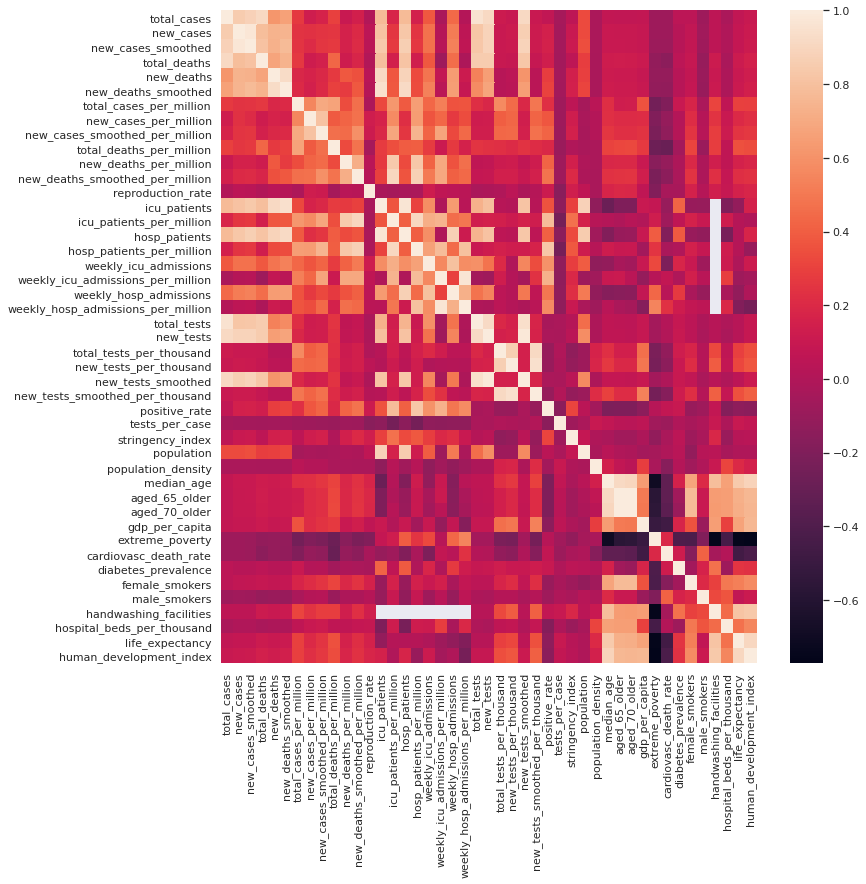

In [12]:
sns.heatmap(covid.corr())

In [13]:
covid_africa = covid[covid['continent'] == 'Africa']
covid_asia = covid[covid['continent'] == 'Asia']
covid_europe = covid[covid['continent'] == 'Europe']
covid_north = covid[covid['continent'] == 'North America']
covid_south = covid[covid['continent'] == 'South America']
covid_oceania = covid[covid['continent'] == 'Oceania']

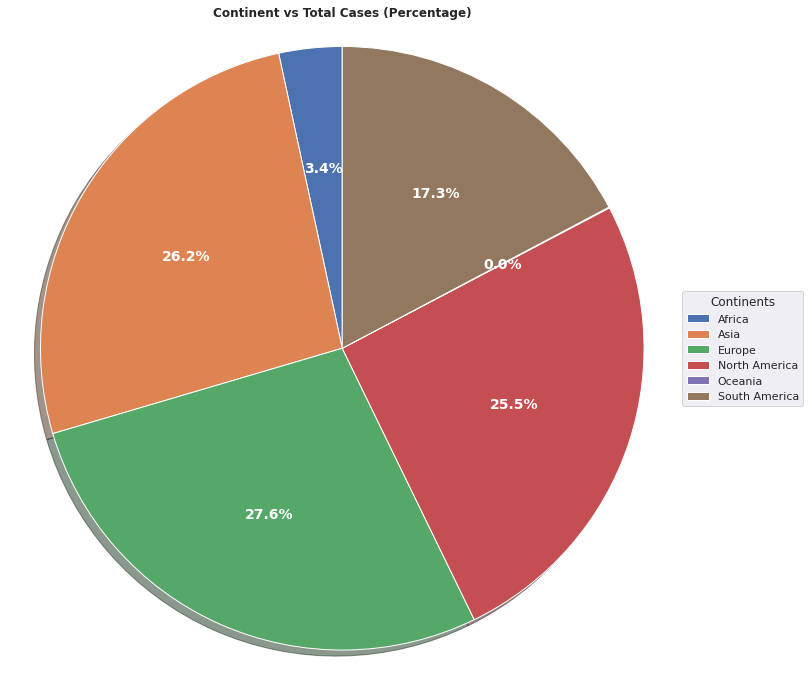

In [14]:
# Pie chart for the New cases vs Continent
total_cases_by_continent = covid.groupby(['continent']).sum('new_cases').reset_index()
continent_labels = total_cases_by_continent['continent'].unique()
sizes = (total_cases_by_continent.groupby(['continent']).sum('new_cases')['new_cases'].values / np.sum(total_cases_by_continent['new_cases']))*100

fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes, labels=continent_labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops=dict(color="w"))
ax1.axis('equal')
ax1.set_title('Continent vs Total Cases (Percentage)', weight="bold")

ax1.legend(wedges, continent_labels,
          title="Continents",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=14, weight="bold")

plt.show()

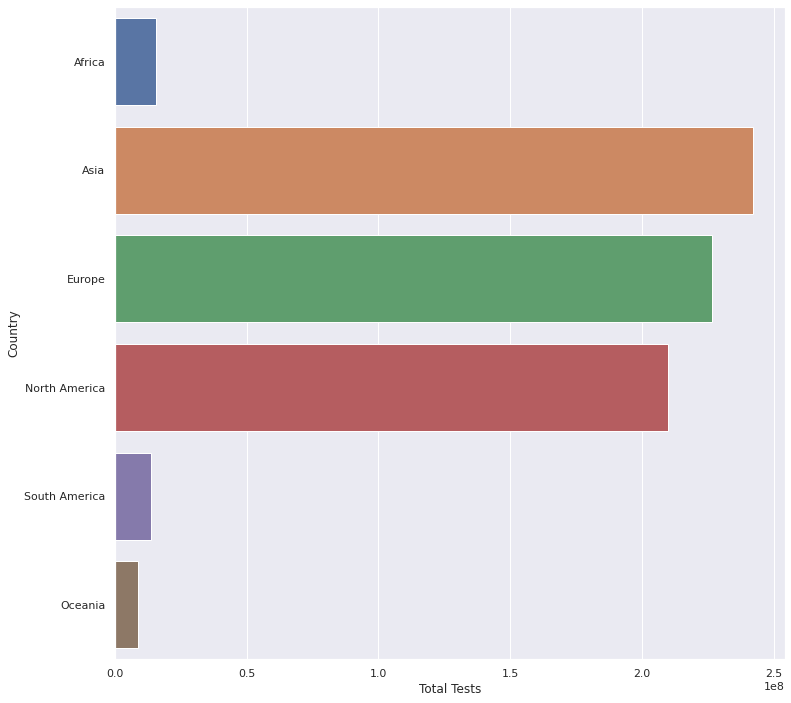

In [15]:
total_tests = []
country = ['Africa', 'Asia', 'Europe', 'North America', 'South America',
       'Oceania']
for i in covid_africa,covid_asia,covid_europe,covid_north,covid_south,covid_oceania:
    total_tests.append(i['new_tests'].sum())
td = {'Country':country,'Total Tests':total_tests}
tests = pd.DataFrame(td)
sns.barplot(data=tests,x='Total Tests',y='Country')
plt.show()

In [16]:
covid['date'] = pd.to_datetime(covid['date'])
covid['year_month'] = covid['date'].dt.to_period('M')
covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,year_month
0,AFG,Asia,Afghanistan,2020-01-23,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,2020-01
1,AFG,Asia,Afghanistan,2020-01-24,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,2020-01
2,AFG,Asia,Afghanistan,2020-01-25,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,2020-01
3,AFG,Asia,Afghanistan,2020-01-26,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,2020-01
4,AFG,Asia,Afghanistan,2020-01-27,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498,2020-01


In [17]:
by_date_continent = covid.groupby(['date', 'continent'])['total_tests'].max().reset_index()
temp = by_date_continent.reset_index()
temp = temp.melt(id_vars=['date', 'continent'], value_vars=['total_tests'],
                var_name='Case', value_name='Count')
fig = px.bar(temp, x="date", y="Count", color='Case', facet_col="Case", facet_row="continent")
fig.update_layout(margin=dict(t=80,l=0,r=0,b=0), height=1200)

In [18]:
by_date_continent = covid.groupby(['date', 'continent'])['new_cases', 'hosp_patients', 'icu_patients', 'new_deaths'].max().reset_index()
temp = by_date_continent.reset_index()
temp = temp.melt(id_vars=['date', 'continent'], value_vars=['new_cases', 'hosp_patients', 'icu_patients', 'new_deaths'],
                var_name='Case', value_name='Count')
fig = px.bar(temp, x="date", y="Count", color='Case', facet_col="Case", facet_row="continent")
fig.update_layout(margin=dict(t=80,l=0,r=0,b=0), height=1200)

In [19]:
covid['death_percentage'] = covid['new_deaths']/covid['total_cases']
# print(covid['new_deaths']/covid['total_cases'])

by_date_continent = covid.groupby(['date', 'continent'])['positive_rate', 'death_percentage'].max().reset_index()
temp = by_date_continent.reset_index()
temp = temp.melt(id_vars=['date', 'continent'], value_vars=['positive_rate','death_percentage'],
                var_name='Case', value_name='Percentage')
fig = px.bar(temp, x="date", y="Percentage", color='Case', facet_col="Case", facet_row="continent")
fig.update_layout(margin=dict(t=80,l=0,r=0,b=0), height=1200)

In [20]:
by_date_continent = covid.groupby(['date', 'continent'])['hospital_beds_per_thousand'].max().reset_index()
temp = by_date_continent.reset_index()
temp = temp.melt(id_vars=['date', 'continent'], value_vars=['hospital_beds_per_thousand'],
                var_name='Case', value_name='Count')
fig = px.bar(temp, x="date", y="Count", color='Case', facet_col="Case", facet_row="continent")
fig.update_layout(margin=dict(t=80,l=0,r=0,b=0), height=1200)

In [78]:
fig = make_subplots(rows=2, cols=2, start_cell="top-left")

fig = px.treemap(covid_europe.sort_values(by='new_cases_per_million', ascending=False).reset_index(drop=True), 
                 path=["location"], values="new_cases_per_million", height=700,
                 title='Number of Confirmed Cases')

fig.data[0].textinfo = 'label+text+value'
fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))
fig #.write_image('covid-eda-8-1.png')

In [24]:
covid_str = covid[covid['stringency_index'].notna()]
top5_stringency_list = covid_str.groupby(['location']).agg({'stringency_index':'mean'}).sort_values(by='stringency_index', ascending=False).head(5)
top5_stringency_list = top5_stringency_list.reset_index()

top5_list = top5_stringency_list['location']
top5_list = top5_list.unique()
top5_list

array(['Honduras', 'Argentina', 'Libya', 'Bolivia', 'Peru'], dtype=object)

In [25]:
by_date_continent = covid.groupby(['date', 'continent', 'location'])['new_cases', 'hosp_patients', 'icu_patients', 'new_deaths'].max().reset_index()
# by_date_continent[by_date_continent['location'].isin([top30_list])]
# by_date_continent['location'].isin([top30_list])

by_date_continent = by_date_continent.loc[by_date_continent['location'].apply(lambda x: x in top5_list)]

temp = by_date_continent.reset_index()
temp = temp.melt(id_vars=['date', 'location'], value_vars=['new_cases', 'hosp_patients', 'icu_patients', 'new_deaths'],
                var_name='Case', value_name='Count')
fig = px.bar(temp, x="date", y="Count", color='Case', facet_col="Case", facet_row="location")
fig.update_layout(margin=dict(t=80,l=0,r=0,b=0), height=2500)

In [26]:
by_date_continent = covid.groupby(['date', 'continent', 'location'])['new_cases', 'hosp_patients', 'icu_patients', 'new_deaths'].max().reset_index()
# by_date_continent[by_date_continent['location'].isin([top30_list])]
# by_date_continent['location'].isin([top30_list])

by_date_continent = by_date_continent.loc[by_date_continent['location'].apply(lambda x: x in top5_list)]

temp = by_date_continent.reset_index()
temp = temp.melt(id_vars=['date', 'location'], value_vars=['new_cases', 'hosp_patients', 'icu_patients', 'new_deaths'],
                var_name='Case', value_name='Count')
fig = px.bar(temp, x="date", y="Count", color='Case', facet_col="Case", facet_row="location")
fig.update_layout(margin=dict(t=80,l=0,r=0,b=0), height=2500)

In [80]:
# fig = px.treemap(covid.sort_values(by='new_cases', ascending=False).reset_index(drop=True), 
#                  path=["location"], values="new_cases", height=700,
#                  title='Number of Confirmed Cases')

# fig.data[0].textinfo = 'label+text+value'
# fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))
# fig #.write_image('covid-eda-8-1.png')

In [28]:
covid_europe['location'].unique()

array(['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macedonia', 'Malta', 'Moldova', 'Monaco', 'Montenegro',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican'],
      dtype=object)

In [29]:
len(covid_europe['location'].unique())

46

In [30]:
covid.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
     

In [31]:
covid_europe.groupby(['location']).agg({'human_development_index':'max', 'gdp_per_capita':'max', 'population':'max', 'life_expectancy':'max', 'extreme_poverty':'max', 'stringency_index':'mean'}).reset_index().sort_values(['human_development_index','life_expectancy'], ascending=False)

,location,human_development_index,gdp_per_capita,population,life_expectancy,extreme_poverty,stringency_index
31,Norway,0.953,64800.057,5421242.0,82.40,0.2,40.546095
42,Switzerland,0.944,57410.166,8654618.0,83.78,NaN,43.320863
18,Ireland,0.938,67335.293,4937796.0,82.30,0.2,58.958585
14,Germany,0.936,45229.245,83783945.0,81.33,NaN,53.241891
17,Iceland,0.935,46482.958,341250.0,82.99,0.2,40.911950
41,Sweden,0.933,46949.283,10099270.0,82.80,0.5,48.695719
30,Netherlands,0.931,48472.545,17134873.0,82.28,NaN,50.402332
10,Denmark,0.929,46682.515,5792203.0,80.90,0.2,47.900863
44,United Kingdom,0.922,39753.244,67886004.0,81.32,0.2,59.219329
12,Finland,0.920,40585.721,5540718.0,81.91,NaN,38.783548


In [32]:
not_countries = ['Andorra', 'Liechtenstein', 'Monaco', 'San Marino', 'Vatican', 'Kosovo']
covid_europe = covid_europe[~covid_europe['location'].isin(not_countries)]
covid_europe['location'].unique()

array(['Albania', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Macedonia', 'Malta',
       'Moldova', 'Montenegro', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'],
      dtype=object)

In [33]:
from sklearn.impute import SimpleImputer

In [34]:
imp_mf = SimpleImputer(strategy='most_frequent')
imp_zero = SimpleImputer(strategy='constant', fill_value=0)

In [35]:
extreme_poverty_imputed = covid_europe.loc[:,'extreme_poverty'].reset_index()
extreme_poverty_imputed = imp_mf.fit_transform(extreme_poverty_imputed).tolist()
extreme_poverty_imputed = [row[1] for row in extreme_poverty_imputed]

covid_europe['extreme_poverty_imputed'] = extreme_poverty_imputed

In [36]:
covid_europe[covid_europe['stringency_index'].isnull()][['location','date']]['location'].unique()

array(['Albania', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania',
       'Luxembourg', 'Macedonia', 'Malta', 'Montenegro', 'Netherlands',
       'Norway', 'Poland', 'Romania', 'Serbia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'], dtype=object)

In [37]:
stringency_index_imputed = covid_europe.loc[:,'stringency_index'].reset_index()
stringency_index_imputed = imp_zero.fit_transform(stringency_index_imputed).tolist()
stringency_index_imputed = [row[1] for row in stringency_index_imputed]

covid_europe['stringency_index_imputed'] = stringency_index_imputed

In [38]:
covid_europe.isnull().sum()

iso_code                                  0
continent                                 0
location                                  0
date                                      0
total_cases                            1275
new_cases                                 0
new_cases_smoothed                      200
total_deaths                           2101
new_deaths                                0
new_deaths_smoothed                     200
total_cases_per_million                1275
new_cases_per_million                     0
new_cases_smoothed_per_million          200
total_deaths_per_million               2101
new_deaths_per_million                    0
new_deaths_smoothed_per_million         200
reproduction_rate                      2694
icu_patients                           8278
icu_patients_per_million               8278
hosp_patients                          7302
hosp_patients_per_million              7302
weekly_icu_admissions                 12302
weekly_icu_admissions_per_millio

In [39]:
covid_europe_ = covid_europe.groupby(['location']).agg({'human_development_index':'max', 'gdp_per_capita':'max', 'population':'max', 'life_expectancy':'max', 'extreme_poverty_imputed':'max', 'stringency_index_imputed':'mean'}).reset_index().sort_values(['human_development_index'], ascending=False)
covid_europe_ = covid_europe_.set_index('location')

In [40]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 

In [41]:
covid_europe_standardized = preprocessing.scale(covid_europe_)
covid_europe_standardized = pd.DataFrame(covid_europe_standardized)
print(covid_europe_standardized)

           0         1         2         3         4         5
0   1.457536  1.798610 -0.451522  0.894126 -0.449925 -0.291697
1   1.309979  1.375823 -0.341171  1.299812 -0.449925 -0.128898
2   1.211607  1.943655 -0.468022  0.864728 -0.449925  0.944025
3   1.178817  0.678932  2.222900  0.579572 -0.449925  0.502120
4   1.162422  0.750659 -0.624896  1.067571 -0.449925 -0.242494
5   1.129631  0.777338 -0.291867  1.011716 -0.189099  0.218928
6   1.096841  0.864487 -0.051751  0.858849 -0.449925  0.329370
7   1.064050  0.762076 -0.438862  0.453163 -0.449925  0.167490
8   0.949284  0.365641  1.680323  0.576633 -0.449925  0.899949
9   0.916493  0.413269 -0.447445  0.750078 -0.449925 -0.446580
10  0.850912  0.531860 -0.241003  0.667765 -0.449925  0.559059
11  0.719750  0.690800 -0.329165  0.641307 -0.015215  0.106190
12  0.654170  3.485090 -0.615179  0.850030 -0.449925 -0.150961
13  0.604984  0.299987  1.591161  0.970559 -0.449925  0.739553
14  0.523008 -0.112214 -0.565591  0.576633 -0.449925  0

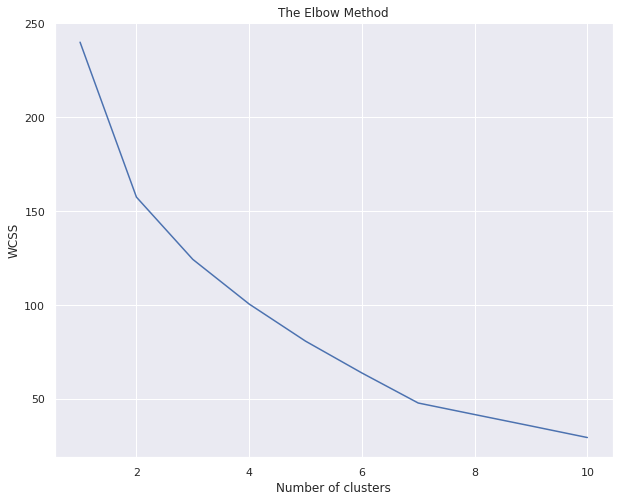

In [42]:
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(covid_europe_standardized)
    wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [43]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++')
y_kmeans = kmeans.fit_predict(covid_europe_standardized)

y_kmeans

array([5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 0, 4, 0, 4, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 6, 2, 1, 3, 2, 1, 1, 1, 3, 1, 1], dtype=int32)

In [44]:
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans+1

# New list called cluster
cluster = list(y_kmeans1)
# Adding cluster to our data set
covid_europe_['cluster'] = cluster

In [45]:
#Mean of clusters 1 to 7
kmeans_mean_cluster = pd.DataFrame(round(covid_europe_.groupby('cluster').mean(),1))
kmeans_mean_cluster

,human_development_index,gdp_per_capita,population,life_expectancy,extreme_poverty_imputed,stringency_index_imputed
cluster,,,,,,
1,0.9,28318.5,8107539.5,79.0,0.6,47.2
2,0.8,11535.6,11279896.3,75.2,0.6,51.8
3,0.8,23363.5,3506307.3,78.1,0.5,4.6
4,0.8,18212.2,10660531.0,75.9,5.4,24.9
5,0.9,38616.1,64832014.4,82.5,0.7,56.4
6,0.9,54644.7,7194905.6,82.3,0.3,46.1
7,0.8,24766.0,145934460.0,72.6,0.1,54.7


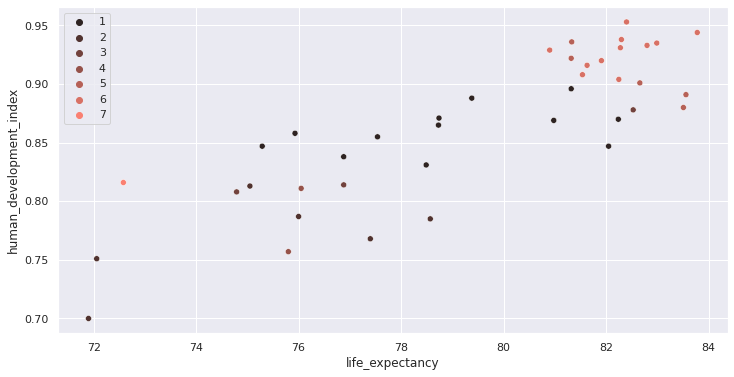

In [46]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=covid_europe_['life_expectancy'], y = covid_europe_['human_development_index'], hue=y_kmeans1, palette='dark:salmon')

In [47]:
covid_europe_.reset_index().sort_values('cluster')['cluster'].value_counts()

1    12
6    11
2     6
5     5
3     3
4     2
7     1
Name: cluster, dtype: int64

In [48]:
covid_europe_.reset_index().sort_values('cluster')

,location,human_development_index,gdp_per_capita,population,life_expectancy,extreme_poverty_imputed,stringency_index_imputed,cluster
19,Estonia,0.871,29481.252,1326539.0,78.74,0.5,32.755566,1
14,Slovenia,0.896,31400.840,2078932.0,81.32,0.2,46.673805,1
20,Greece,0.870,24574.382,10423056.0,82.24,1.5,53.201478,1
21,Cyprus,0.869,32415.132,875899.0,80.98,0.2,54.584340,1
22,Poland,0.865,27216.445,37846605.0,78.73,0.2,46.696541,1
23,Lithuania,0.858,29524.265,2722291.0,75.93,0.7,45.264119,1
24,Slovakia,0.855,30155.152,5459643.0,77.54,0.7,46.702642,1
25,Latvia,0.847,25063.846,1886202.0,75.29,0.7,42.807893,1
27,Hungary,0.838,26777.561,9660350.0,76.88,0.5,48.756195,1
28,Croatia,0.831,22669.797,4105268.0,78.49,0.7,43.970503,1


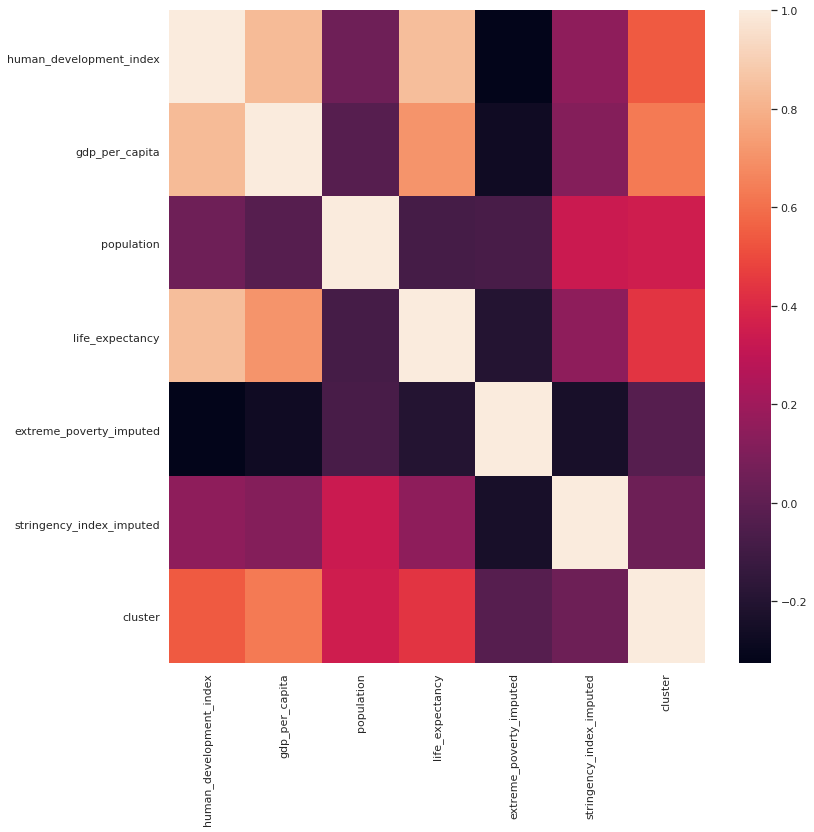

In [49]:
sns.heatmap(covid_europe_.corr())

In [50]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [51]:
covid_europe_X = covid_europe_.drop(['cluster'], axis=1)
covid_europe_y = covid_europe_['cluster']

In [52]:
lr = LinearRegression()

In [53]:
predicted = lr.fit(X=covid_europe_X, y = covid_europe_y)

In [54]:
print(predicted.coef_, "\n", predicted.intercept_) 

[-9.50545056e-01  8.17375203e-05  3.18697929e-08  4.92705180e-02
  2.84400878e-01 -2.11771141e-02] 
 -2.194577111913563


In [55]:
 # Make it look a little nicer

# get the intercept along with other coefficients
values = np.append(predicted.intercept_, predicted.coef_)

# get the names of the values
names = np.append('intercept', covid_europe_X.columns)

# put everything in a labeled dataframe
results = pd.DataFrame(values, index = names, columns=['coef'])

print(results)

                                  coef
intercept                -2.194577e+00
human_development_index  -9.505451e-01
gdp_per_capita            8.173752e-05
population                3.186979e-08
life_expectancy           4.927052e-02
extreme_poverty_imputed   2.844009e-01
stringency_index_imputed -2.117711e-02


In [56]:
X = sm.add_constant(covid_europe_X)
model = sm.OLS(covid_europe_y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cluster   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     7.732
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           3.07e-05
Time:                        00:39:42   Log-Likelihood:                -69.499
No. Observations:                  40   AIC:                             153.0
Df Residuals:                      33   BIC:                             164.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.1946      7.552     -0.291      0.773     -17.559      13.170
human_development_index     -0.9505      9.824     -0.097      0.924     -20.938      19.037
gdp_per_capita            8.174e-05   2.47e-05      3.304      0.002    3.14e-05       0.000
population                3.187e-08    9.1e-09      3.504      0.001    1.34e-08    5.04e-08
life_expectancy              0.0493      0.137      0.359      0.722      -0.230       0.329
extreme_poverty_imputed      0.2844      0.228      1.247      0.221      -0.180       0.748
stringency_index_imputed    -0.0212      0.017     -1.212      0.234      -0.057       0.014
==============================================================================
Omnibus:                       11.232   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                2.719
Skew:                           0.001   Prob(JB):                        0.257
Kurtosis:                       1.723   Cond. No.                     1.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
X = sm.add_constant(covid_europe_X[['gdp_per_capita','population','life_expectancy','stringency_index_imputed']])
model = sm.OLS(covid_europe_y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cluster   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     11.26
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           5.63e-06
Time:                        00:39:42   Log-Likelihood:                -70.518
No. Observations:                  40   AIC:                             151.0
Df Residuals:                      35   BIC:                             159.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.7959      7.485     -0.240      0.812     -16.991      13.400
gdp_per_capita            7.544e-05   1.93e-05      3.908      0.000    3.63e-05       0.000
population                3.156e-08   8.75e-09      3.607      0.001    1.38e-08    4.93e-08
life_expectancy              0.0416      0.100      0.415      0.681      -0.162       0.246
stringency_index_imputed    -0.0255      0.017     -1.505      0.141      -0.060       0.009
==============================================================================
Omnibus:                       15.918   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.178
Skew:                          -0.100   Prob(JB):                        0.204
Kurtosis:                       1.634   Cond. No.                     1.09e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
X = sm.add_constant(covid_europe_X[['gdp_per_capita','population','stringency_index_imputed']])
model = sm.OLS(covid_europe_y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cluster   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     15.30
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           1.40e-06
Time:                        00:39:42   Log-Likelihood:                -70.616
No. Observations:                  40   AIC:                             149.2
Df Residuals:                      36   BIC:                             156.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.2881      0.821      1.569      0.125      -0.377       2.953
gdp_per_capita            8.104e-05   1.36e-05      5.953      0.000    5.34e-05       0.000
population                3.107e-08   8.57e-09      3.626      0.001    1.37e-08    4.84e-08
stringency_index_imputed    -0.0246      0.017     -1.479      0.148      -0.058       0.009
==============================================================================
Omnibus:                       14.693   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                3.076
Skew:                          -0.093   Prob(JB):                        0.215
Kurtosis:                       1.654   Cond. No.                     1.21e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# evaluation of a model using 10 features chosen with correlation
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# feature selection
def select_features(X_train, y_train):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_regression, k=3)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	
	return X_train_fs, fs


# feature selection
X_train_fs, fs = select_features(covid_europe_X, covid_europe_y)
# fit the model
X = sm.add_constant(X_train_fs)
model = sm.OLS(covid_europe_y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cluster   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     8.084
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           0.000303
Time:                        00:39:42   Log-Likelihood:                -76.757
No. Observations:                  40   AIC:                             161.5
Df Residuals:                      36   BIC:                             168.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2328      8.603      0.143      0.887     -16.215      18.681
x1             4.6498     10.572      0.440      0.663     -16.791      26.090
x2          7.081e-05   2.82e-05      2.513      0.017    1.37e-05       0.000
x3            -0.0521      0.150     -0.349      0.729      -0.355       0.251
==============================================================================
Omnibus:                        2.382   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.333
Skew:                          -0.058   Prob(JB):                        0.513
Kurtosis:                       2.113   Cond. No.                     1.46e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
cols = fs.get_support(indices=True)
features = covid_europe_X.iloc[:,cols]
features

,human_development_index,gdp_per_capita,life_expectancy
location,,,
Norway,0.953,64800.057,82.40
Switzerland,0.944,57410.166,83.78
Ireland,0.938,67335.293,82.30
Germany,0.936,45229.245,81.33
Iceland,0.935,46482.958,82.99
Sweden,0.933,46949.283,82.80
Netherlands,0.931,48472.545,82.28
Denmark,0.929,46682.515,80.90
United Kingdom,0.922,39753.244,81.32


In [61]:
print(X)

[[1.0000000e+00 9.5300000e-01 6.4800057e+04 8.2400000e+01]
 [1.0000000e+00 9.4400000e-01 5.7410166e+04 8.3780000e+01]
 [1.0000000e+00 9.3800000e-01 6.7335293e+04 8.2300000e+01]
 [1.0000000e+00 9.3600000e-01 4.5229245e+04 8.1330000e+01]
 [1.0000000e+00 9.3500000e-01 4.6482958e+04 8.2990000e+01]
 [1.0000000e+00 9.3300000e-01 4.6949283e+04 8.2800000e+01]
 [1.0000000e+00 9.3100000e-01 4.8472545e+04 8.2280000e+01]
 [1.0000000e+00 9.2900000e-01 4.6682515e+04 8.0900000e+01]
 [1.0000000e+00 9.2200000e-01 3.9753244e+04 8.1320000e+01]
 [1.0000000e+00 9.2000000e-01 4.0585721e+04 8.1910000e+01]
 [1.0000000e+00 9.1600000e-01 4.2658576e+04 8.1630000e+01]
 [1.0000000e+00 9.0800000e-01 4.5436686e+04 8.1540000e+01]
 [1.0000000e+00 9.0400000e-01 9.4277965e+04 8.2250000e+01]
 [1.0000000e+00 9.0100000e-01 3.8605671e+04 8.2660000e+01]
 [1.0000000e+00 8.9600000e-01 3.1400840e+04 8.1320000e+01]
 [1.0000000e+00 8.9100000e-01 3.4272360e+04 8.3560000e+01]
 [1.0000000e+00 8.8800000e-01 3.2605906e+04 7.9380000e+0

In [133]:
covid_europe_class = pd.read_csv('/content/covid_europe_classification.csv')
covid_europe_class = covid_europe_class.set_index('location')

In [134]:
covid_europe.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
     

In [135]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [136]:
covid_europe_ts = covid_europe[['location','date','new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']]
covid_europe_ts['date']= pd.to_datetime(covid_europe_ts['date'])
covid_europe_ts = covid_europe_ts.pivot(index='location', columns='date', values='new_cases_per_million')
covid_europe_ts = covid_europe_ts.rolling(7, axis=1, min_periods=1).mean().fillna(0)

In [137]:
model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=1)

In [138]:
X = to_time_series_dataset(covid_europe_ts.copy())

In [139]:
labels = model.fit_predict(X)

In [140]:
location_cluster = {'location': covid_europe_ts.index, 'predicted_cluster': 1 + labels}
location_cluster = pd.DataFrame(location_cluster)
location_clusters = location_cluster.set_index('location').join(covid_europe_class)
location_clusters = location_clusters.reset_index()

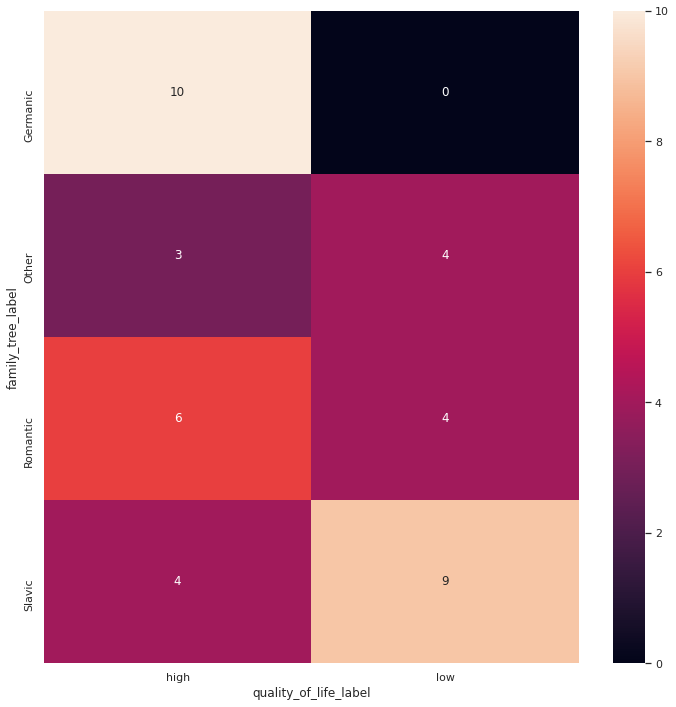

In [141]:
ct_cluster = pd.crosstab(index=location_clusters['family_tree_label'], columns=location_clusters['quality_of_life_label'])
sns.heatmap(ct_cluster, annot = True)

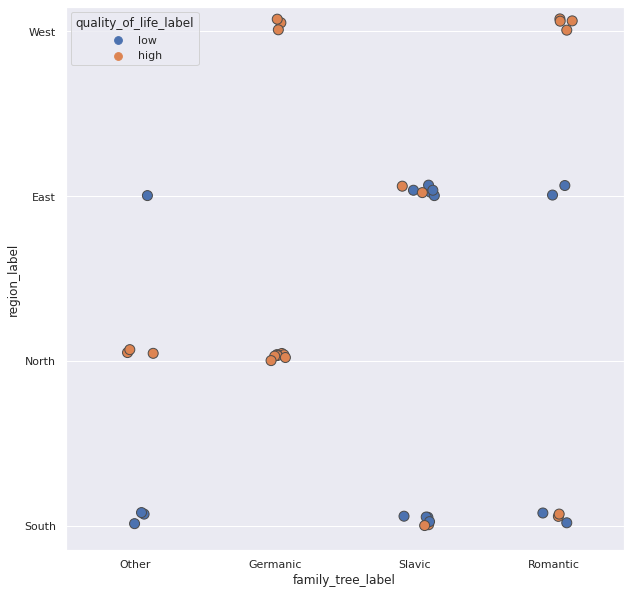

In [142]:
f, ax1 = plt.subplots(1, sharex=True, sharey=False, figsize=(10, 10))

sns.stripplot(data=location_clusters, x = 'family_tree_label', y='region_label', hue='quality_of_life_label', size=10, linewidth=1, ax=ax1)
# sns.stripplot(data=location_clusters, x = 'predicted_cluster', y='region_label', hue='region_label', linewidth=1, ax=ax2)
# sns.stripplot(data=location_clusters, x = 'predicted_cluster', y='quality_of_life_label', hue='quality_of_life_label', linewidth=1, ax=ax3)

for ax in [ax1]:
  for collection in ax.collections:
    dots = collection
    offsets = dots.get_offsets()
    jittered_offsets = offsets + np.random.uniform(0, 0.08, offsets.shape)
    dots.set_offsets(jittered_offsets)

In [143]:
# ts_list = ['new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']

# for i in ts_list:
#     covid_europe_ts = covid_europe[['location','date','new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']]
#     covid_europe_ts['date']= pd.to_datetime(covid_europe_ts['date'])
#     covid_europe_ts = covid_europe_ts.pivot(index='location', columns='date', values=i)
#     covid_europe_ts = covid_europe_ts.rolling(7, axis=1, min_periods=1).mean().fillna(0)

#     model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=1)
#     X = to_time_series_dataset(covid_europe_ts.copy())
#     labels = model.fit_predict(X)

#     clusters = pd.Series(data=labels, index=covid_europe_ts.index)

#     colors = ['blue', 'red', 'green', 'orange']
#     names = ['blue cluster', 'red cluster', 'green cluster', 'orange cluster']

#     f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(30, 20))
    
#     for cluster, ax in zip([0,1,2,3],[ax1,ax2,ax3,ax4]):
#         data = covid_europe_ts.loc[clusters[clusters == cluster].index]
#         data.T.plot(legend=False, alpha=.2,color='black', ax=ax)
#         data.mean(axis=0).plot(linewidth=3., color=colors[cluster], ax=ax)
#         ax.set_title("Cluster: " + str(cluster + 1))
#     f.suptitle('Title: ' + i)
#     plt.tight_layout(pad=3.0)
#     # plt.show()

#     location_cluster = {'location': covid_europe_ts.index, 'predicted_cluster': 1 + labels}
#     location_cluster = pd.DataFrame(location_cluster)
#     location_clusters = location_cluster.set_index('location').join(covid_europe_class)
#     location_clusters = location_clusters.reset_index()
    
#     f, (ax5, ax6, ax7) = plt.subplots(1, 3, figsize=(30,8))
#     annot_kws={'fontsize':16, 'weight': 'bold'}
#     # Confusion matrix
#     cluster_list = ['region_label', 'family_tree_label', 'quality_of_life_label']
#     for i, ax in zip(cluster_list,[ax5,ax6,ax7]):
#         ct_cluster = pd.crosstab(index=location_clusters['predicted_cluster'], columns=location_clusters[i])
#         sns.heatmap(ct_cluster, annot = True, ax=ax, annot_kws=annot_kws)
#     plt.tight_layout(pad=3.0) 
#     plt.show()
#     plt.subplots_adjust(bottom = 0.2);

## Reducing family tree label to Slavic and Germanic

In [144]:
covid_europe_gs = covid_europe.set_index('location').join(covid_europe_class)
covid_europe_gs = covid_europe_gs[covid_europe_gs['family_tree_label'].isin(['Slavic','Germanic'])].reset_index()
covid_europe_gs.head()

,location,iso_code,continent,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,extreme_poverty_imputed,stringency_index_imputed,region,family_tree,tourism,region_label,family_tree_label,tourism_label,quality_of_life,quality_of_life_label,health_care,health_care_label,health_care_value
0,Austria,AUT,Europe,2020-01-23,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,NaN,7.37,81.54,0.908,0.7,0.0,4,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
1,Austria,AUT,Europe,2020-01-24,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,NaN,7.37,81.54,0.908,0.7,0.0,4,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
2,Austria,AUT,Europe,2020-01-25,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,NaN,7.37,81.54,0.908,0.7,0.0,4,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
3,Austria,AUT,Europe,2020-01-26,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,NaN,7.37,81.54,0.908,0.7,0.0,4,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
4,Austria,AUT,Europe,2020-01-27,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9006400.0,106.749,44.4,19.202,13.748,45436.686,0.7,145.183,6.35,28.4,30.9,NaN,7.37,81.54,0.908,0.7,0.0,4,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56


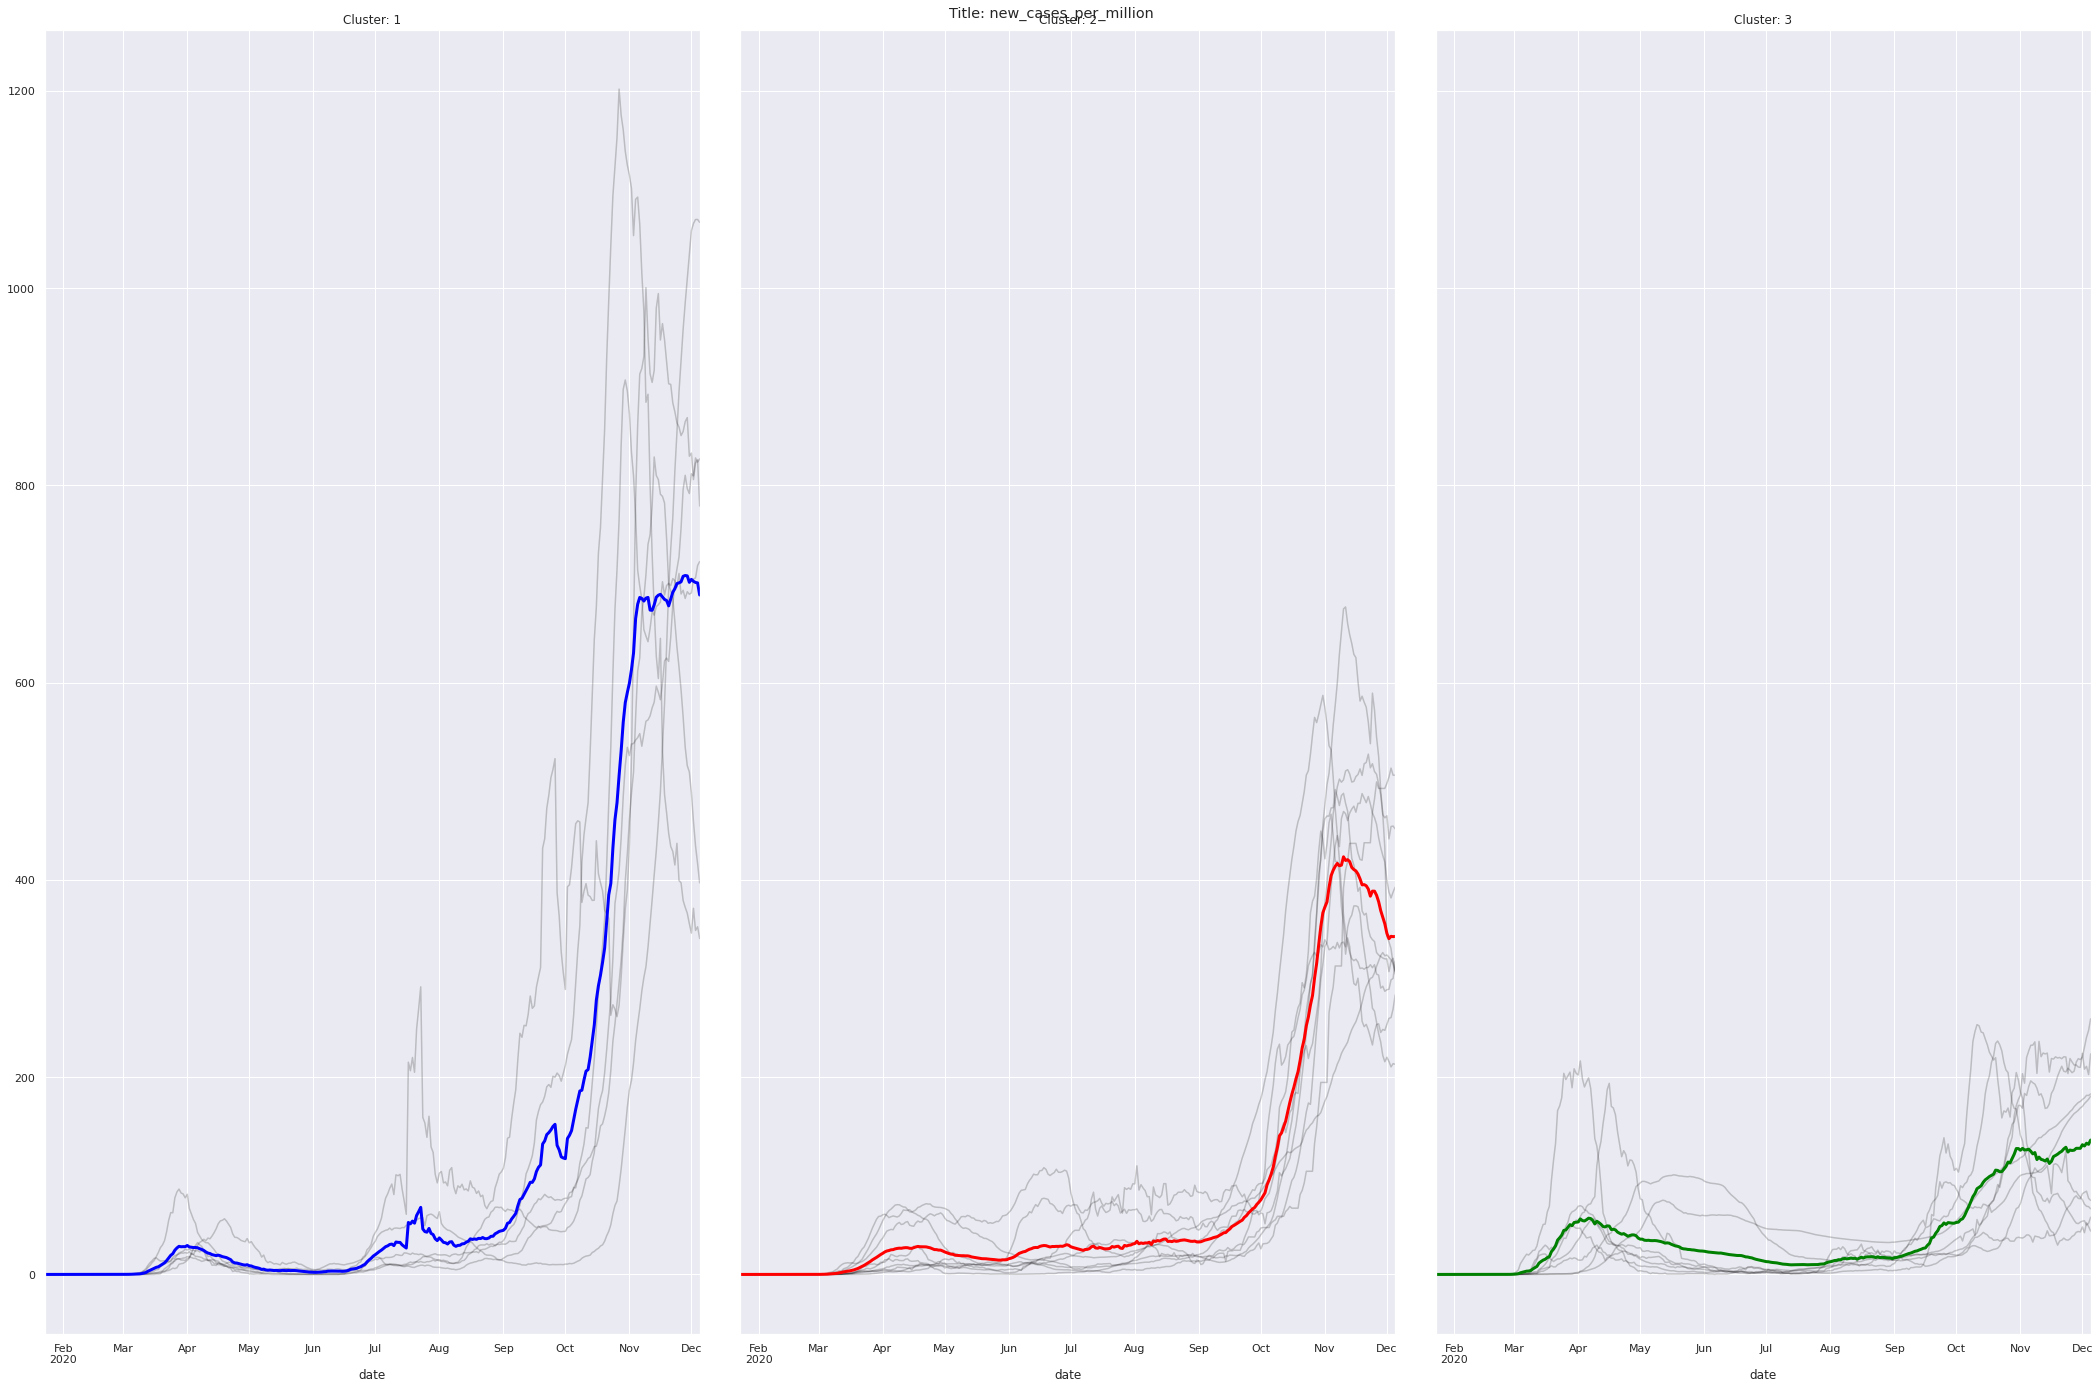

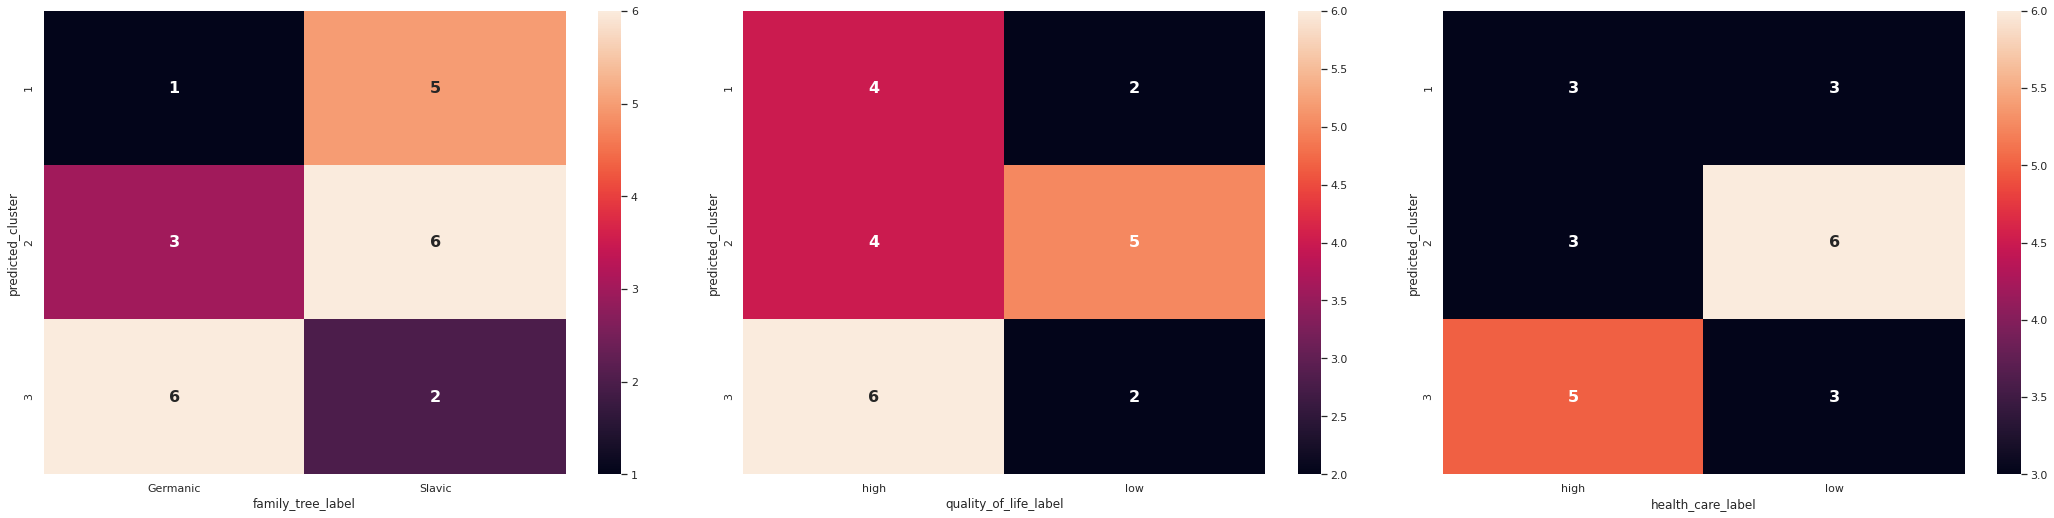

<Figure size 864x864 with 0 Axes>

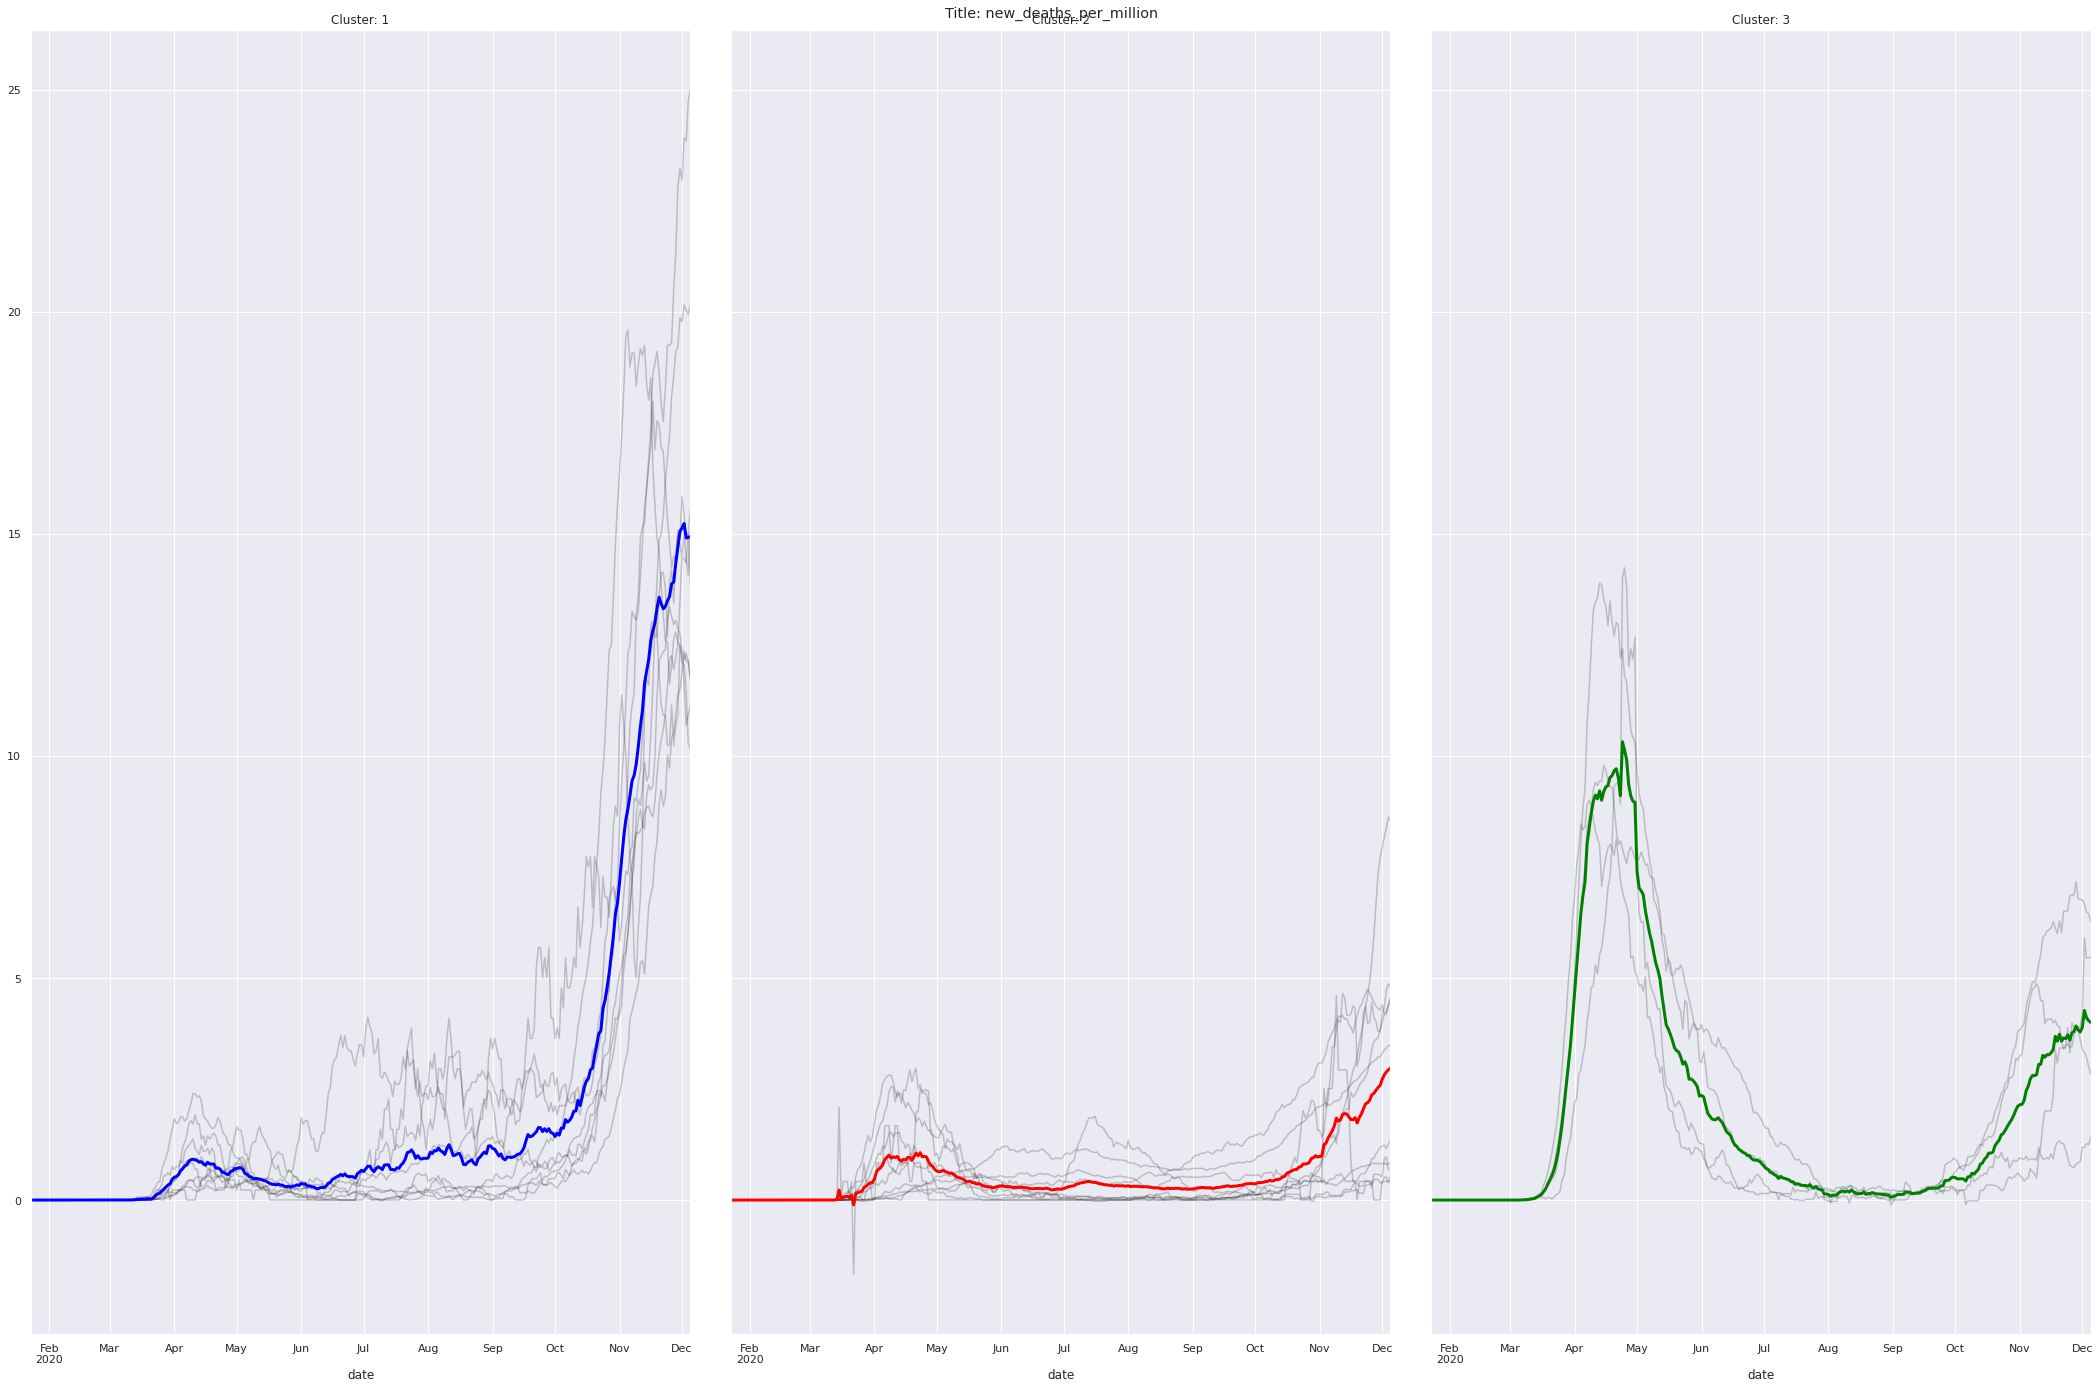

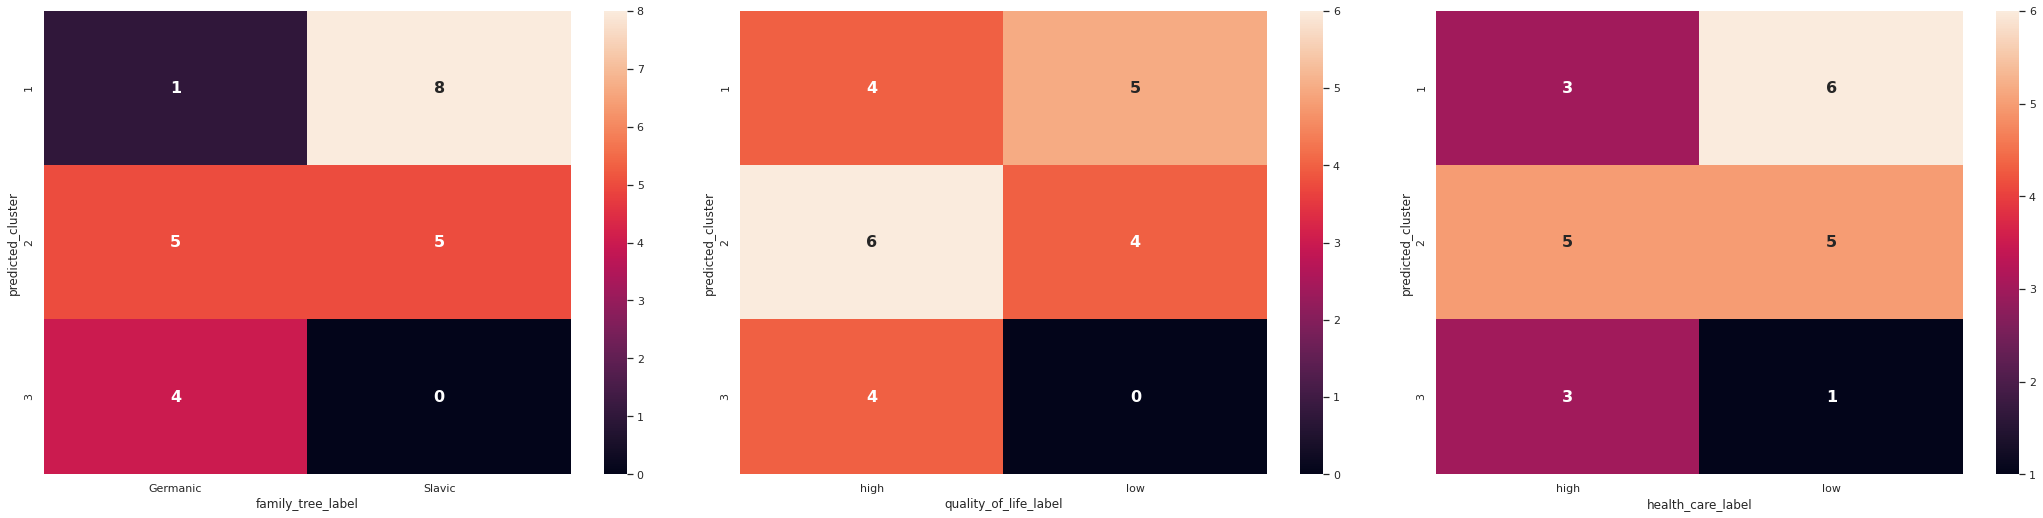

<Figure size 864x864 with 0 Axes>

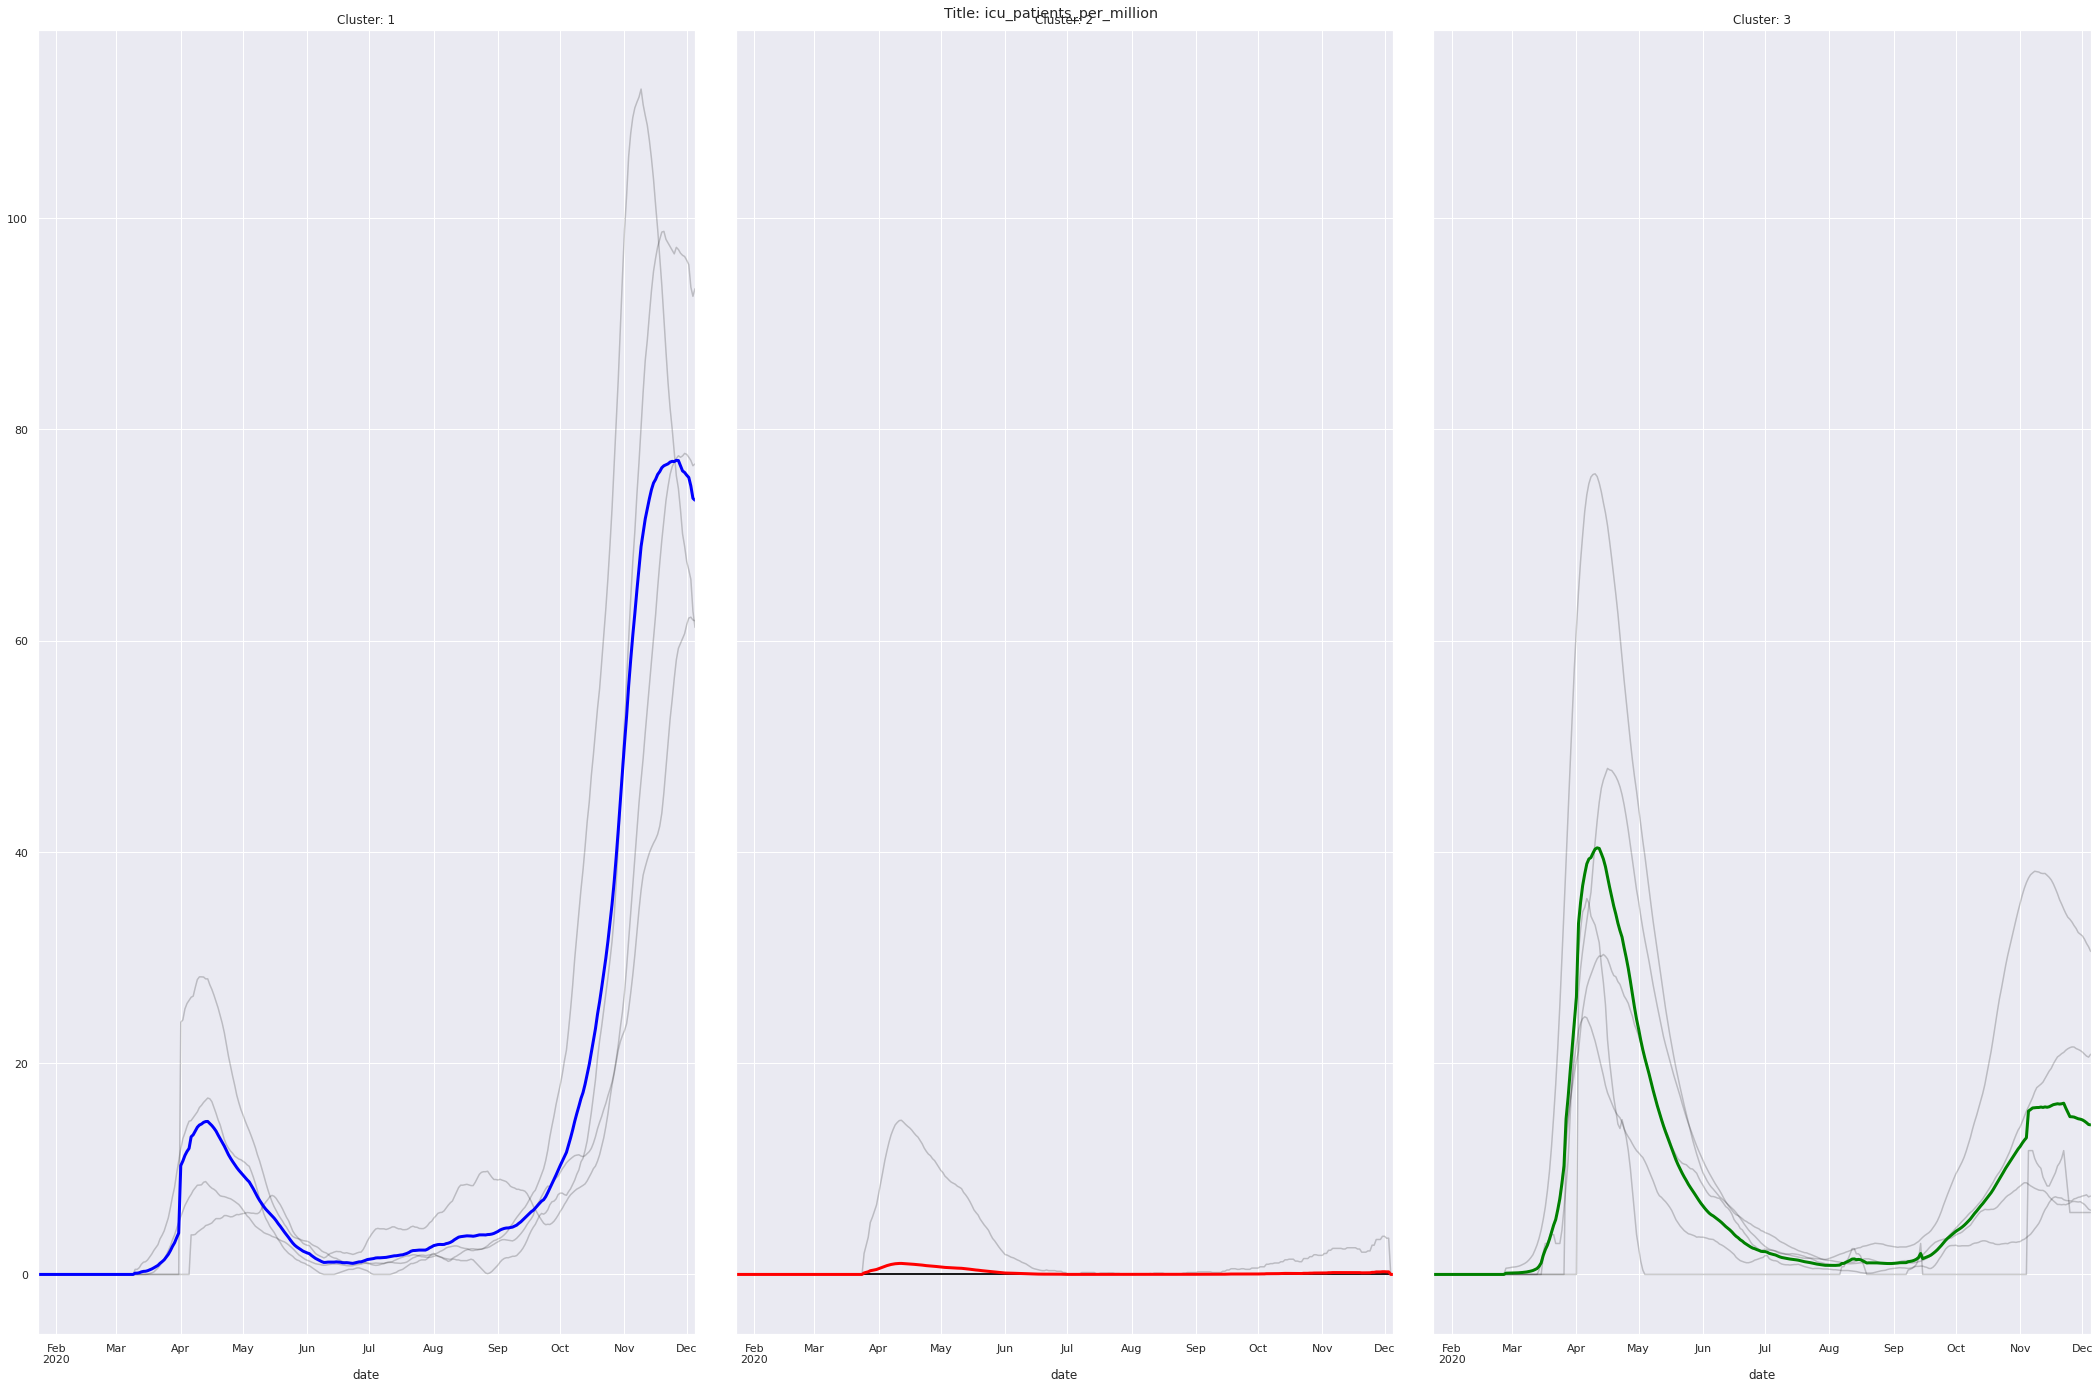

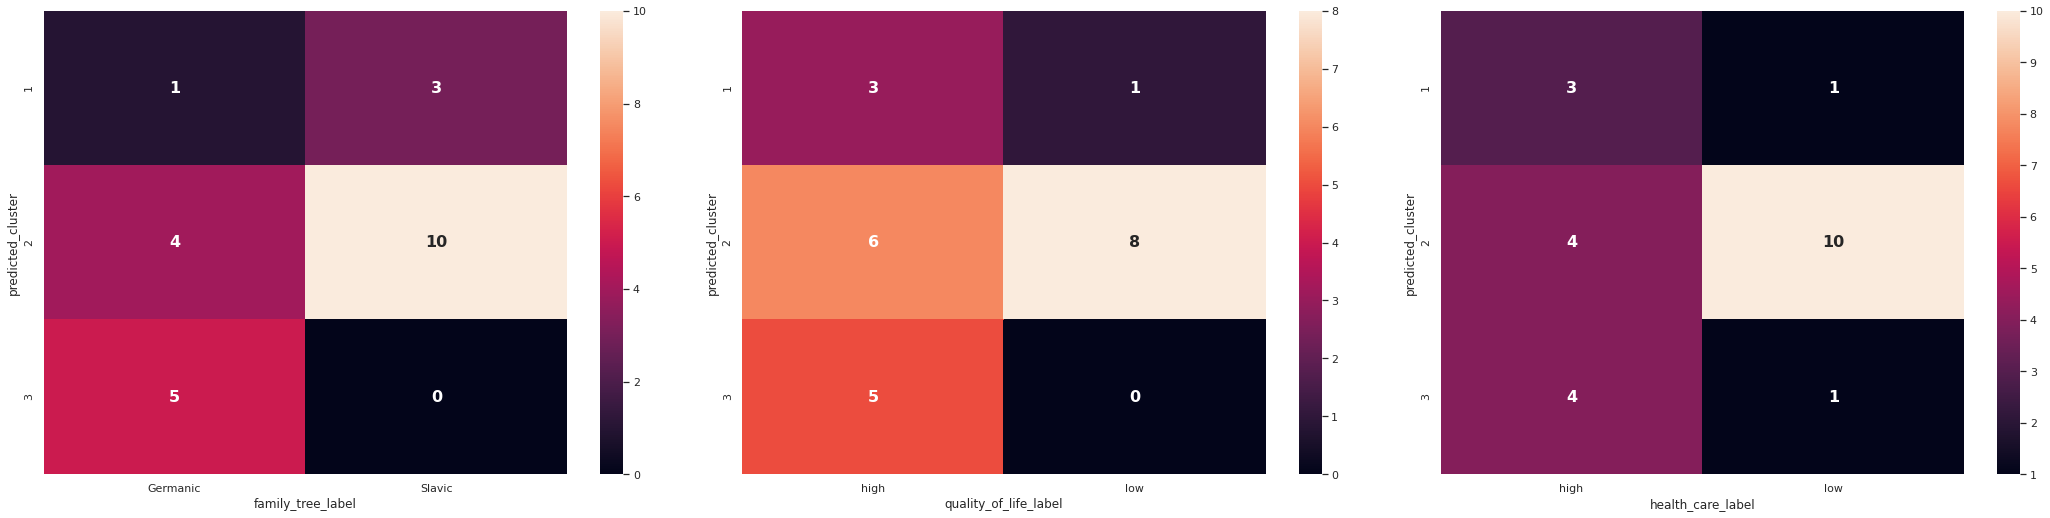

<Figure size 864x864 with 0 Axes>

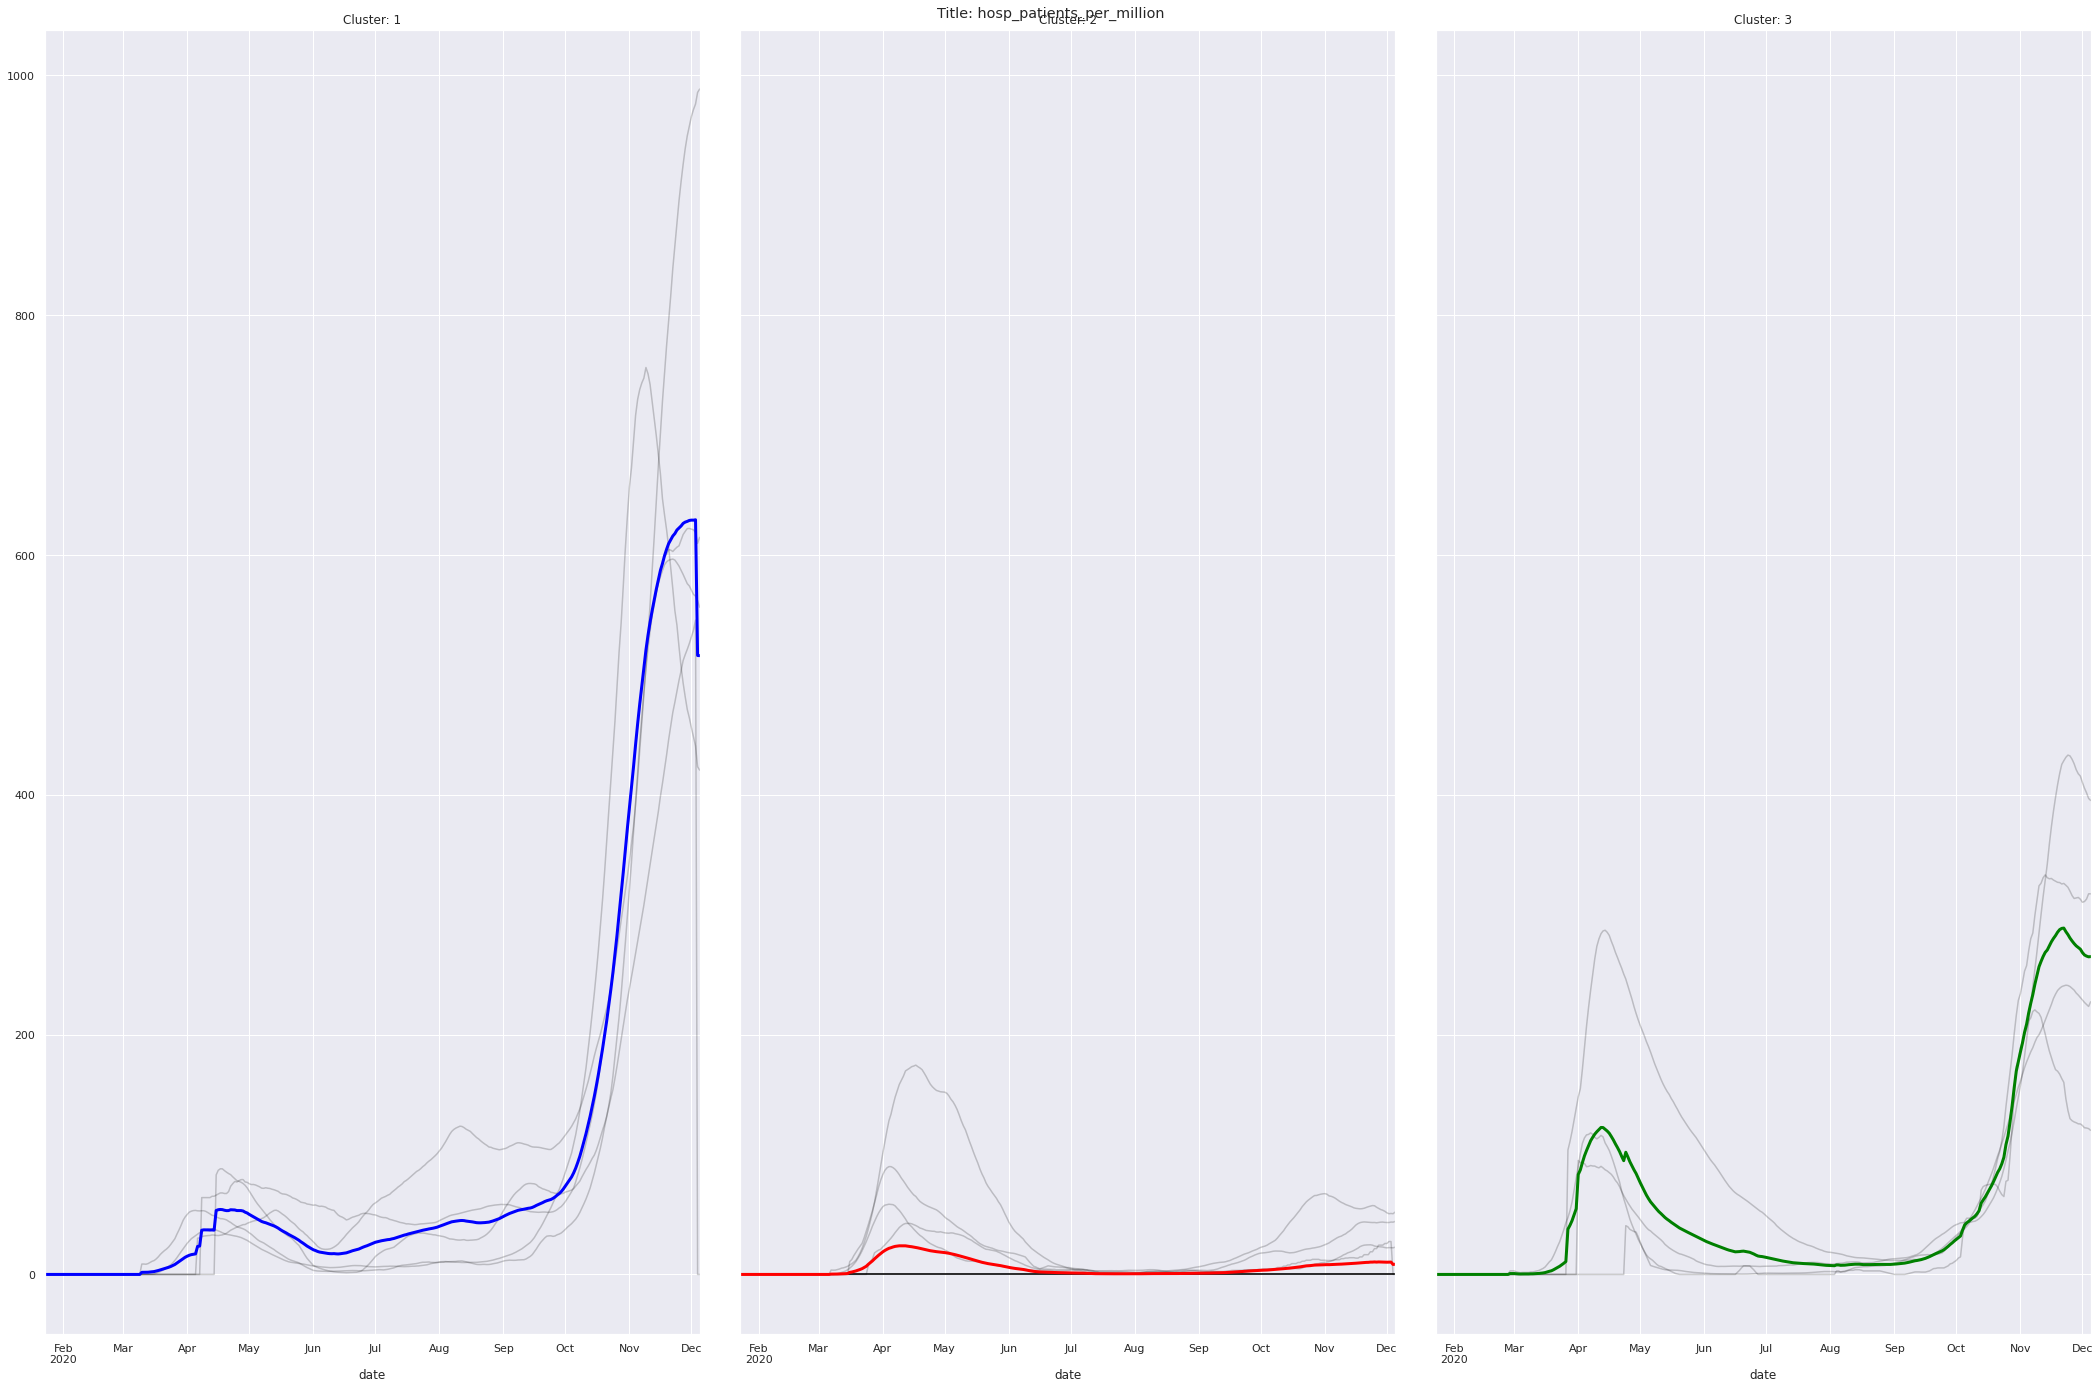

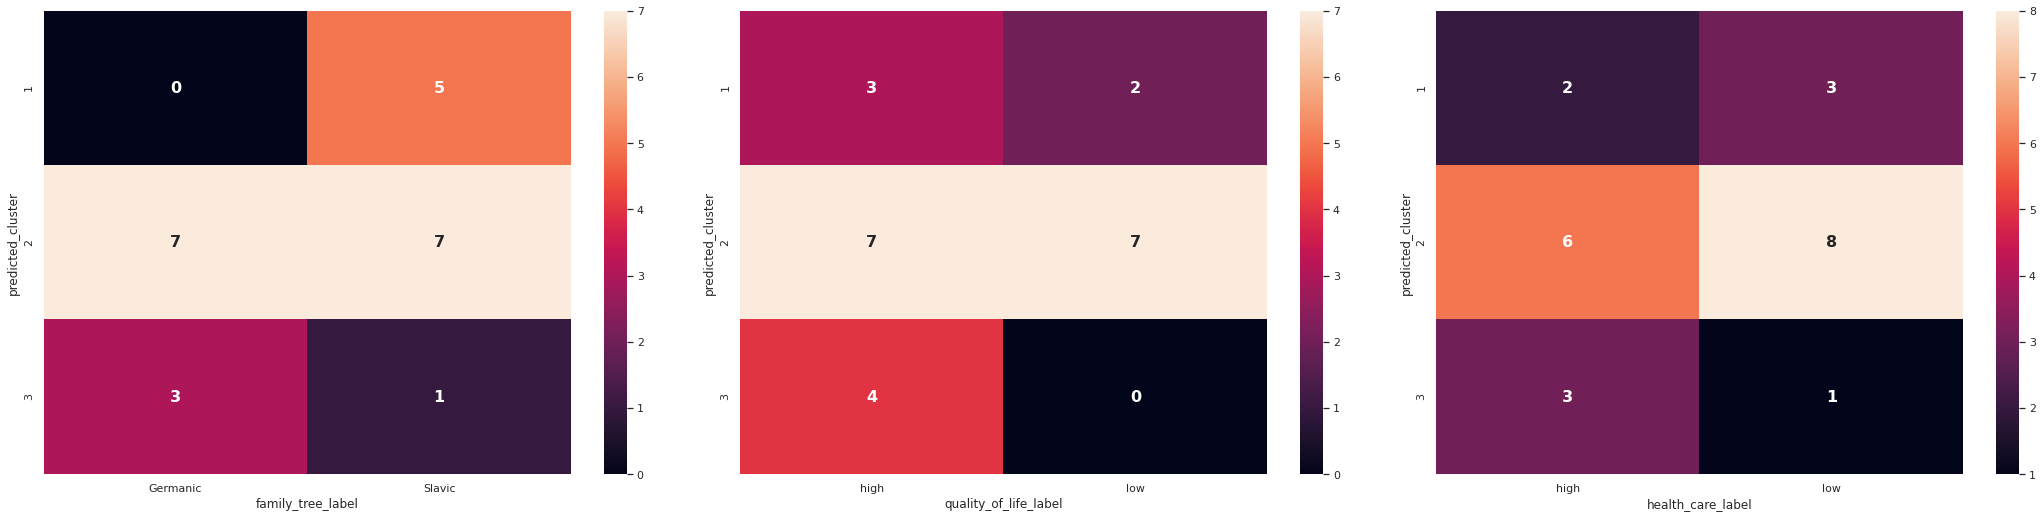

<Figure size 864x864 with 0 Axes>

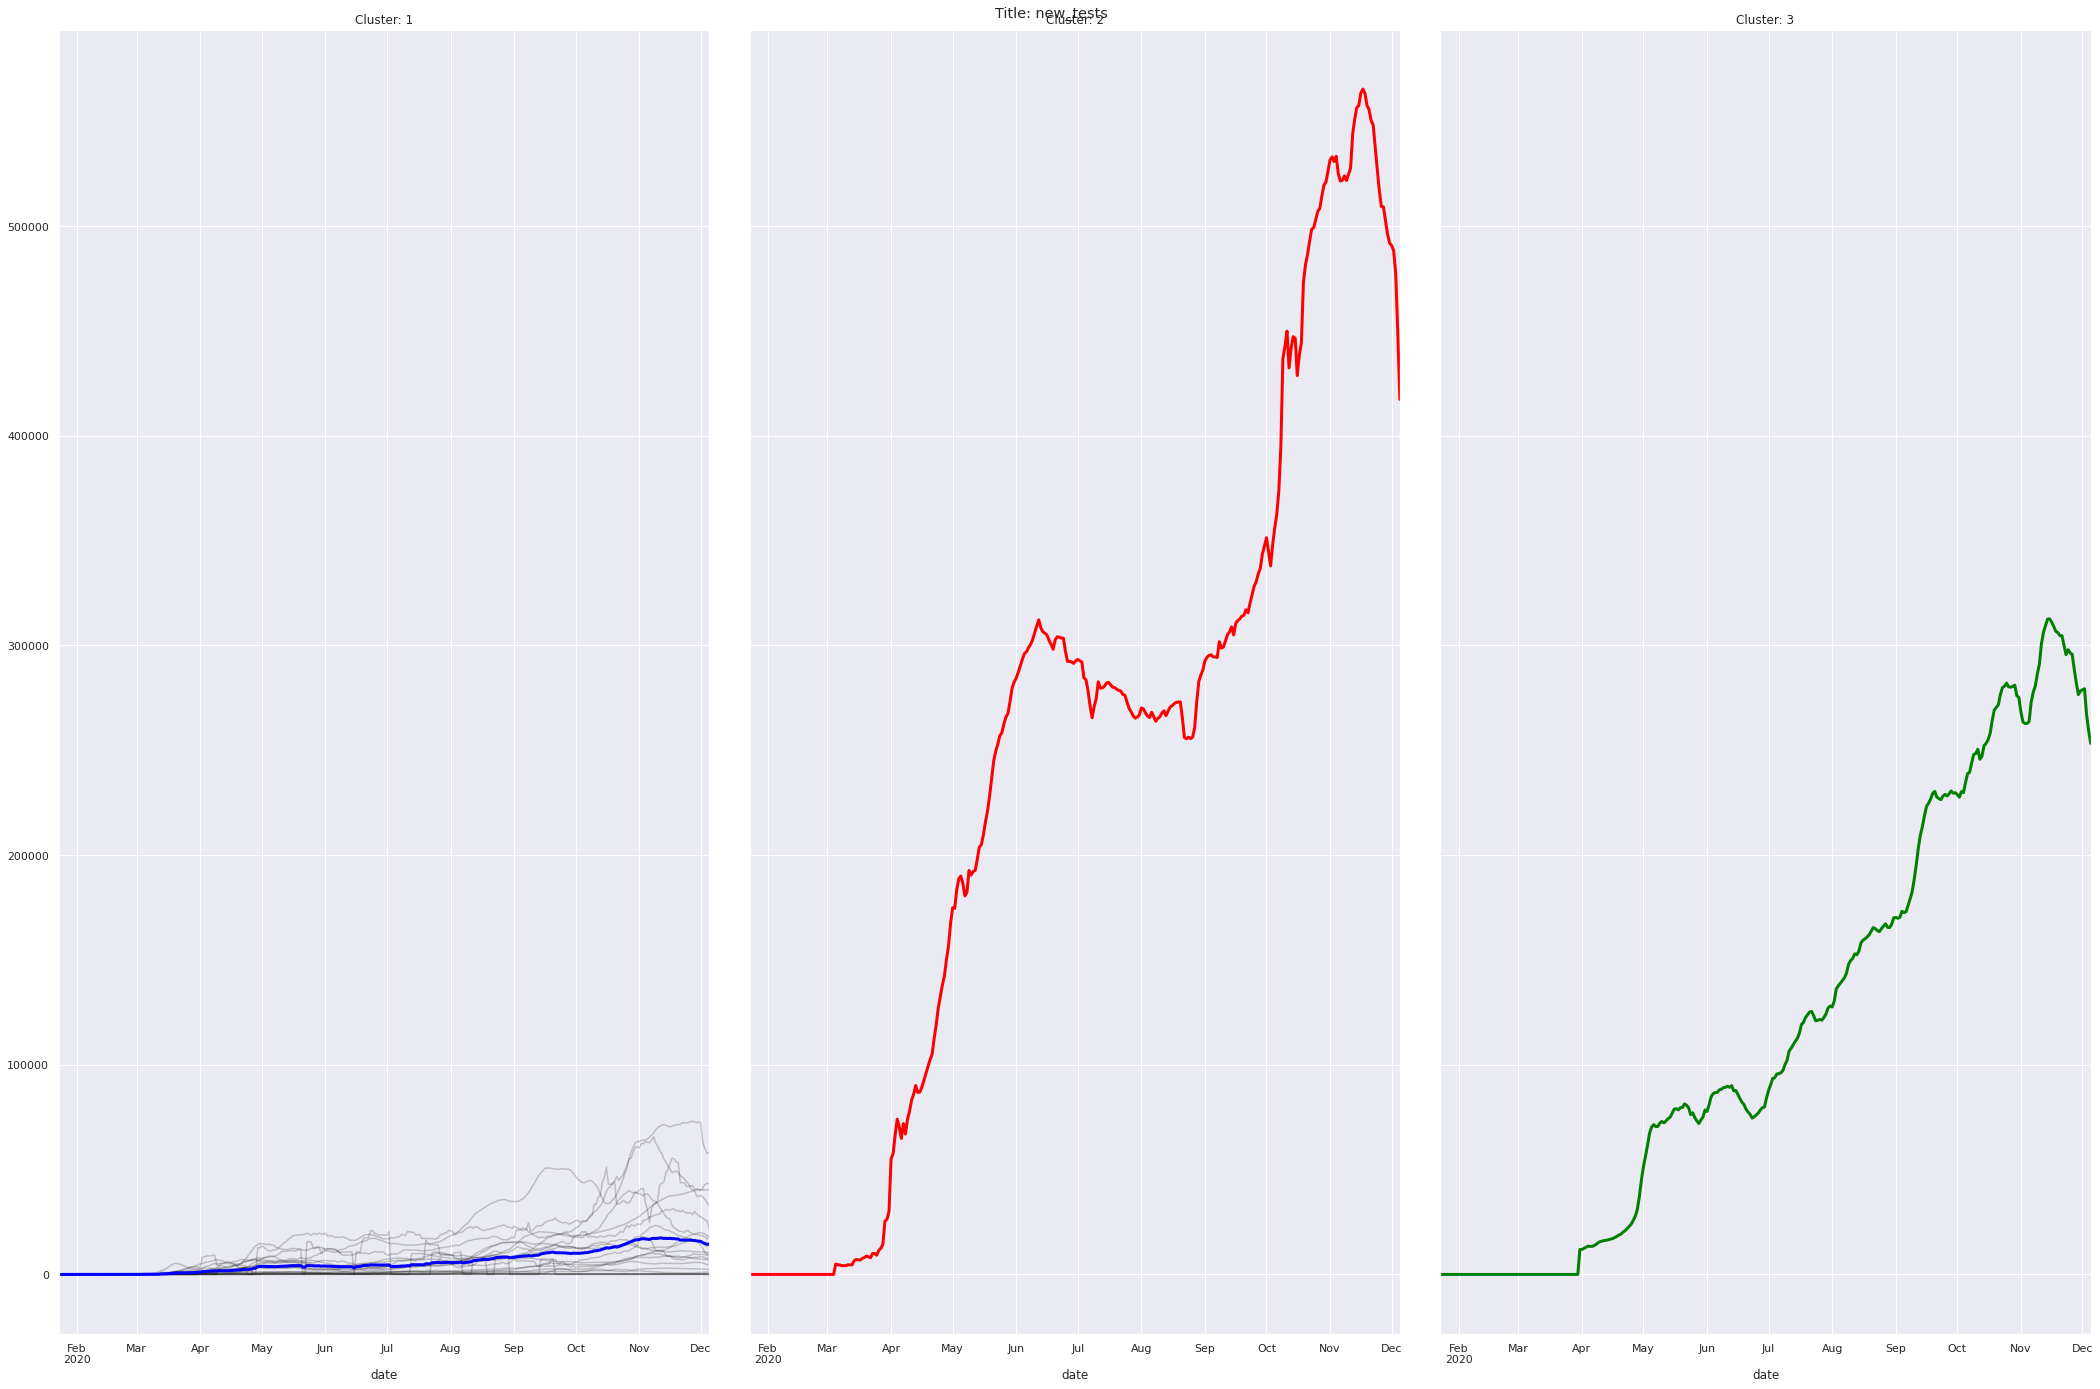

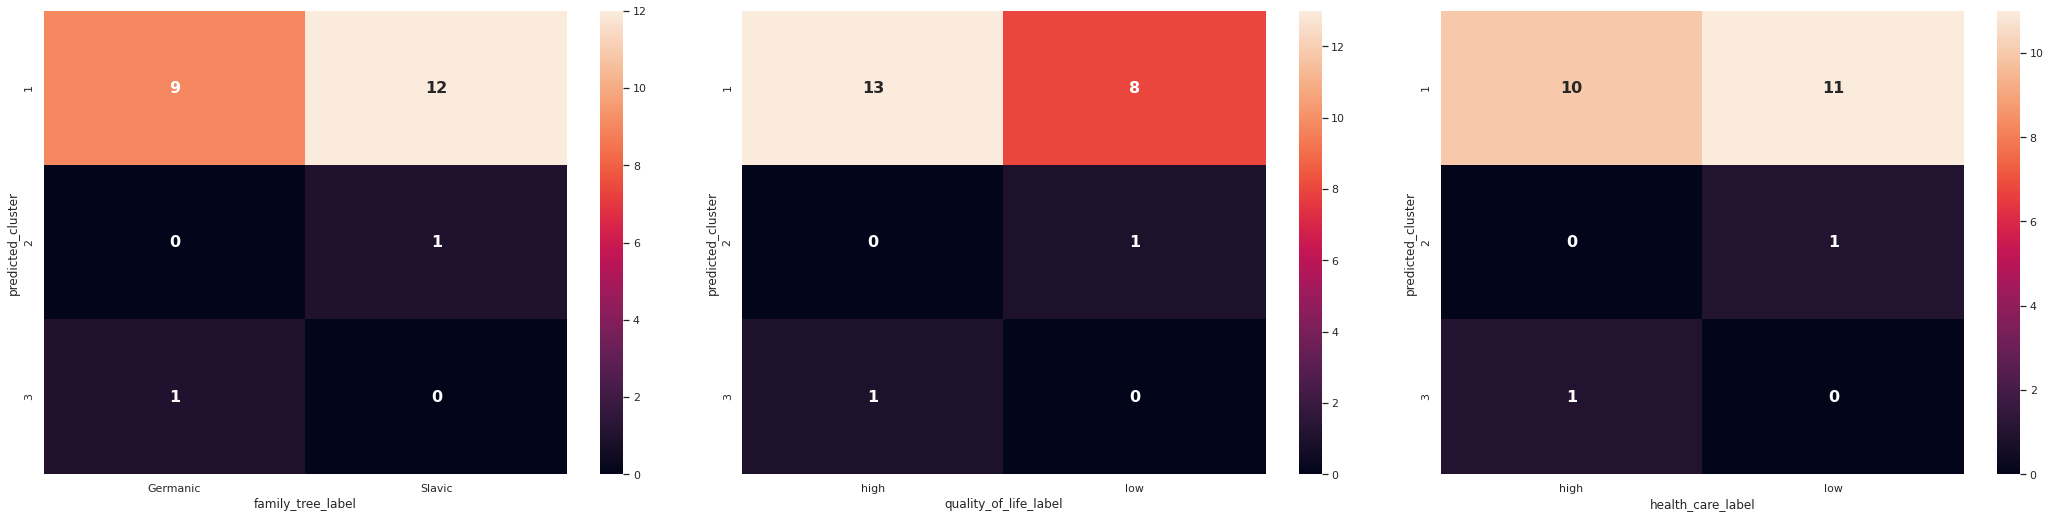

<Figure size 864x864 with 0 Axes>

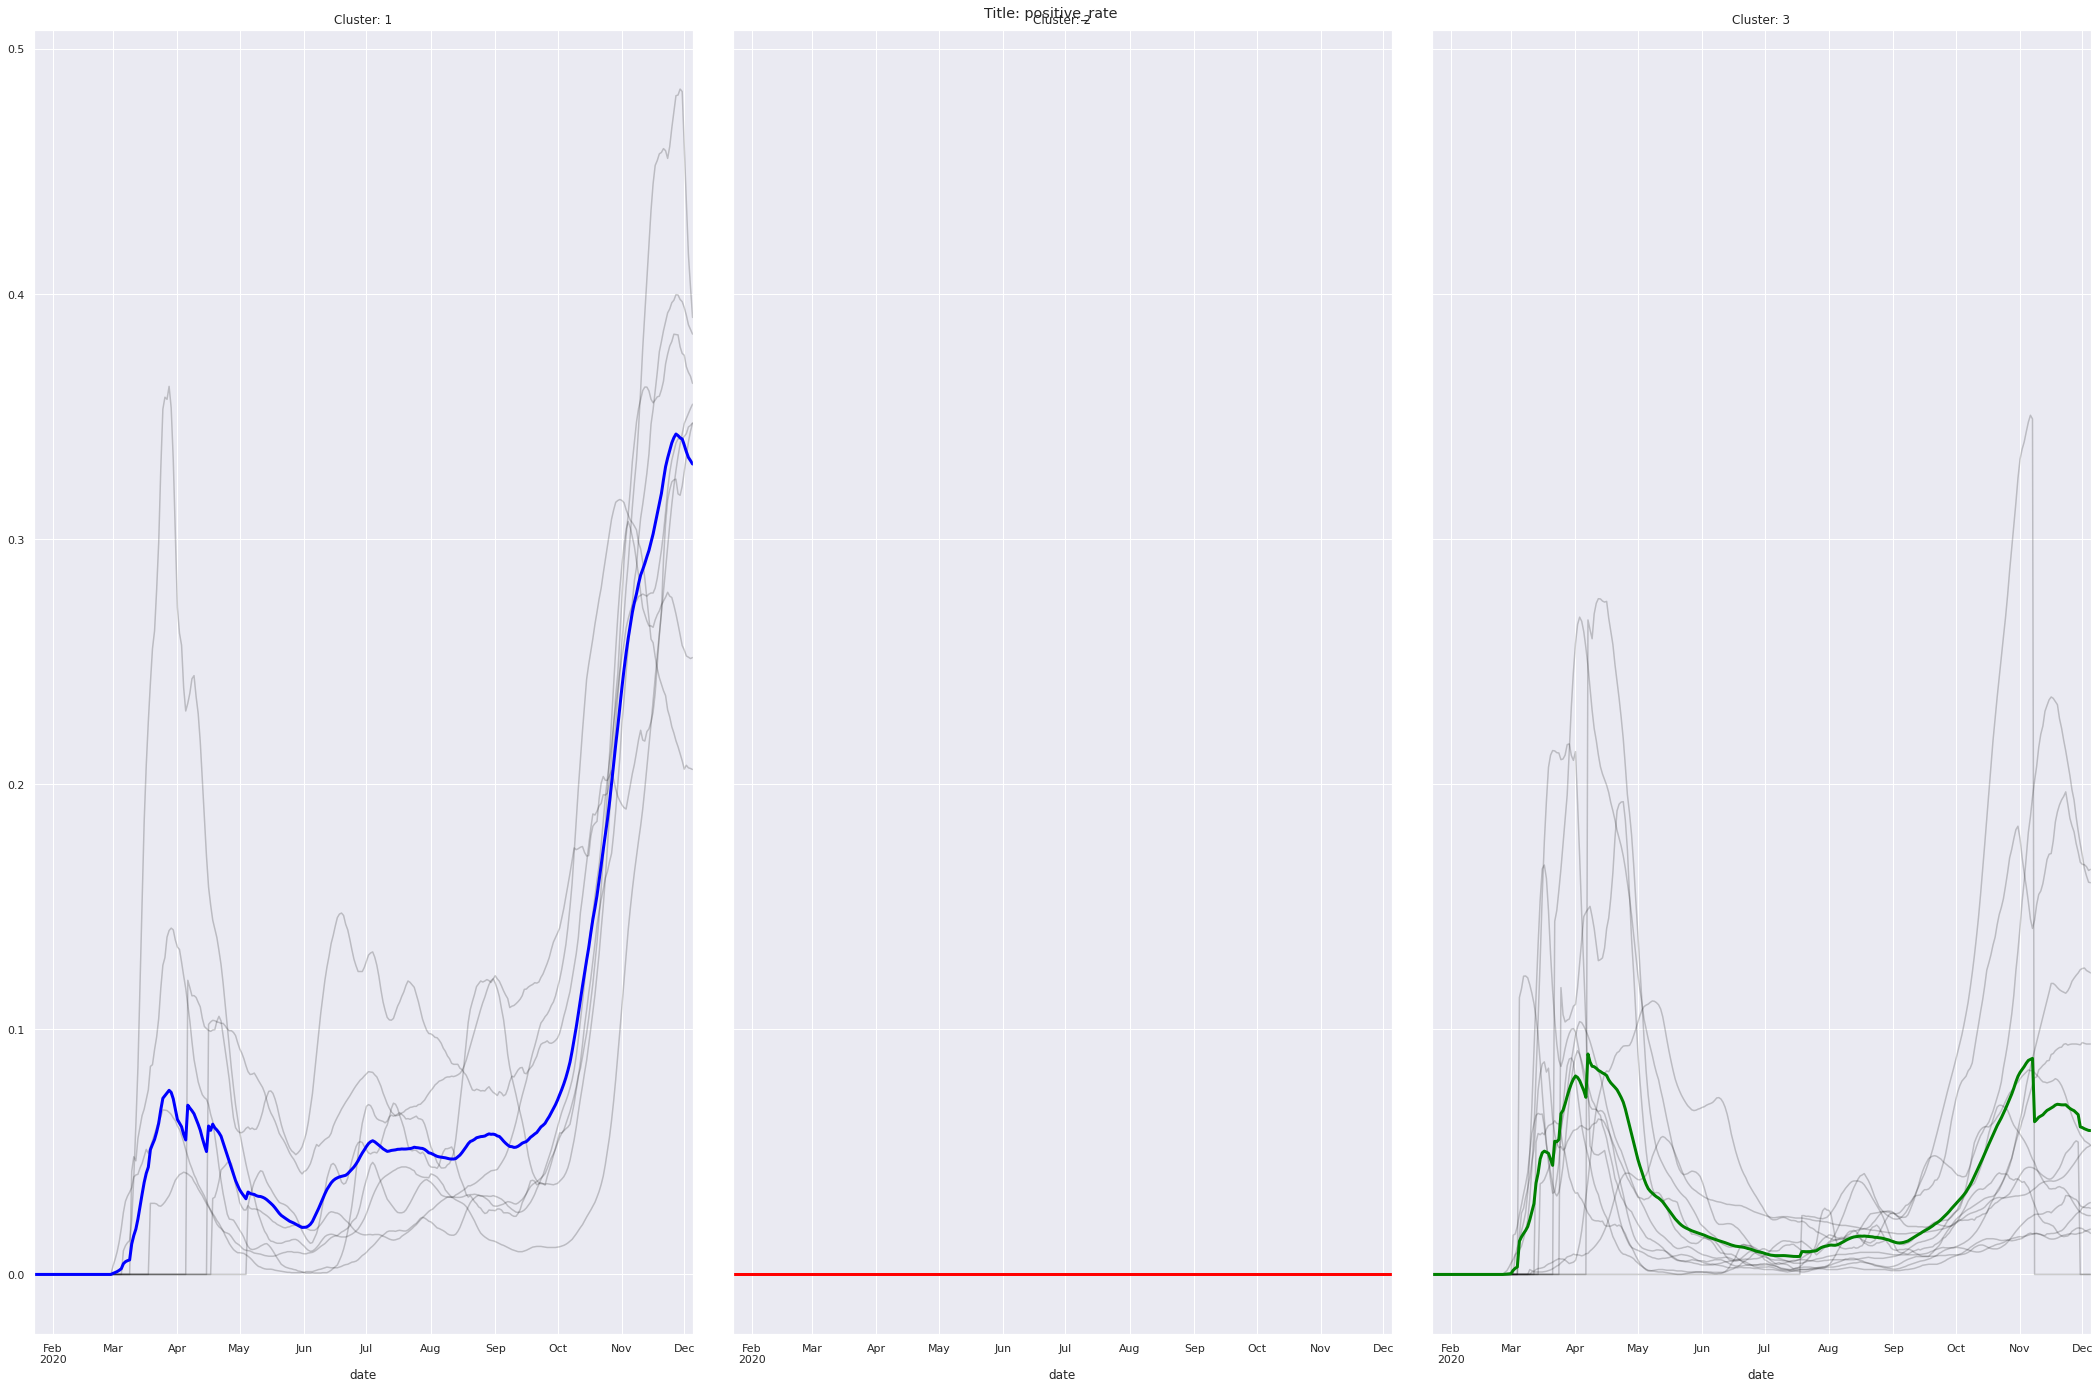

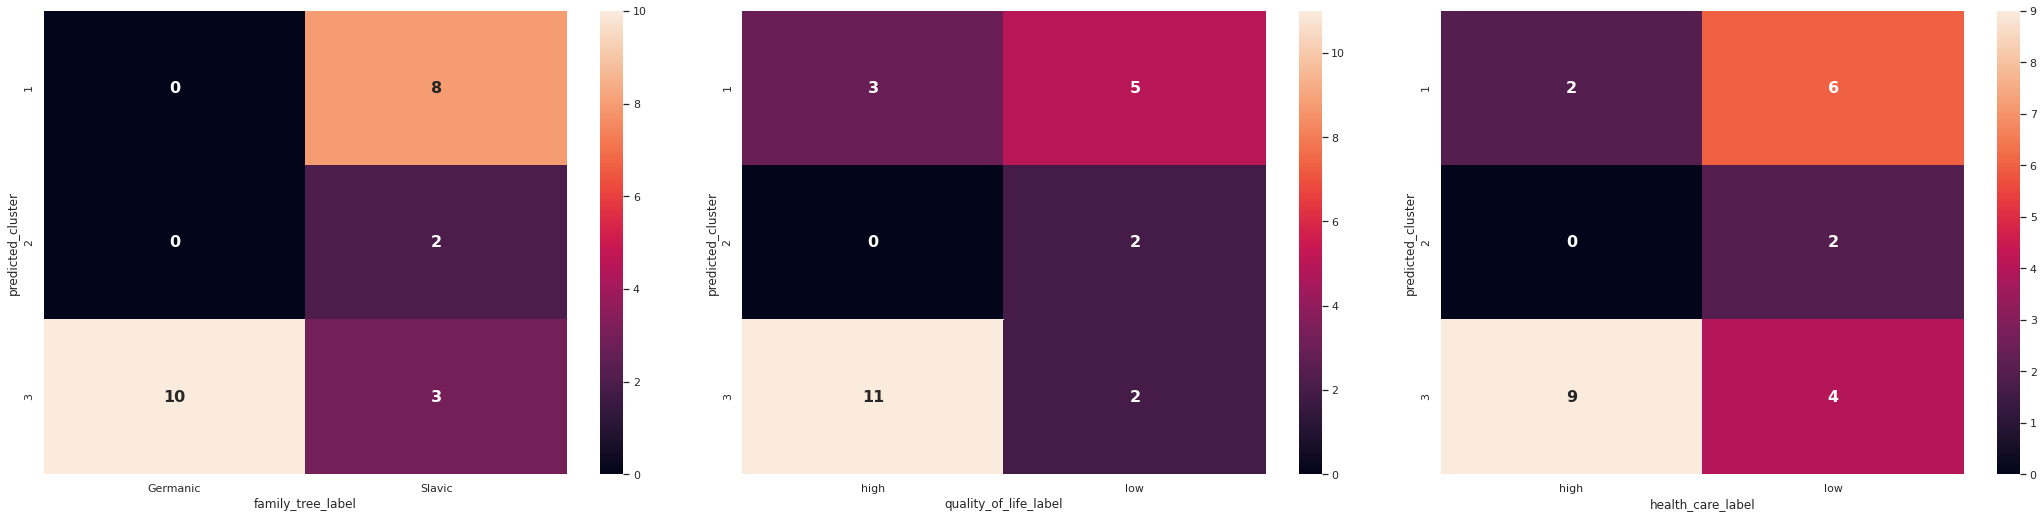

<Figure size 864x864 with 0 Axes>

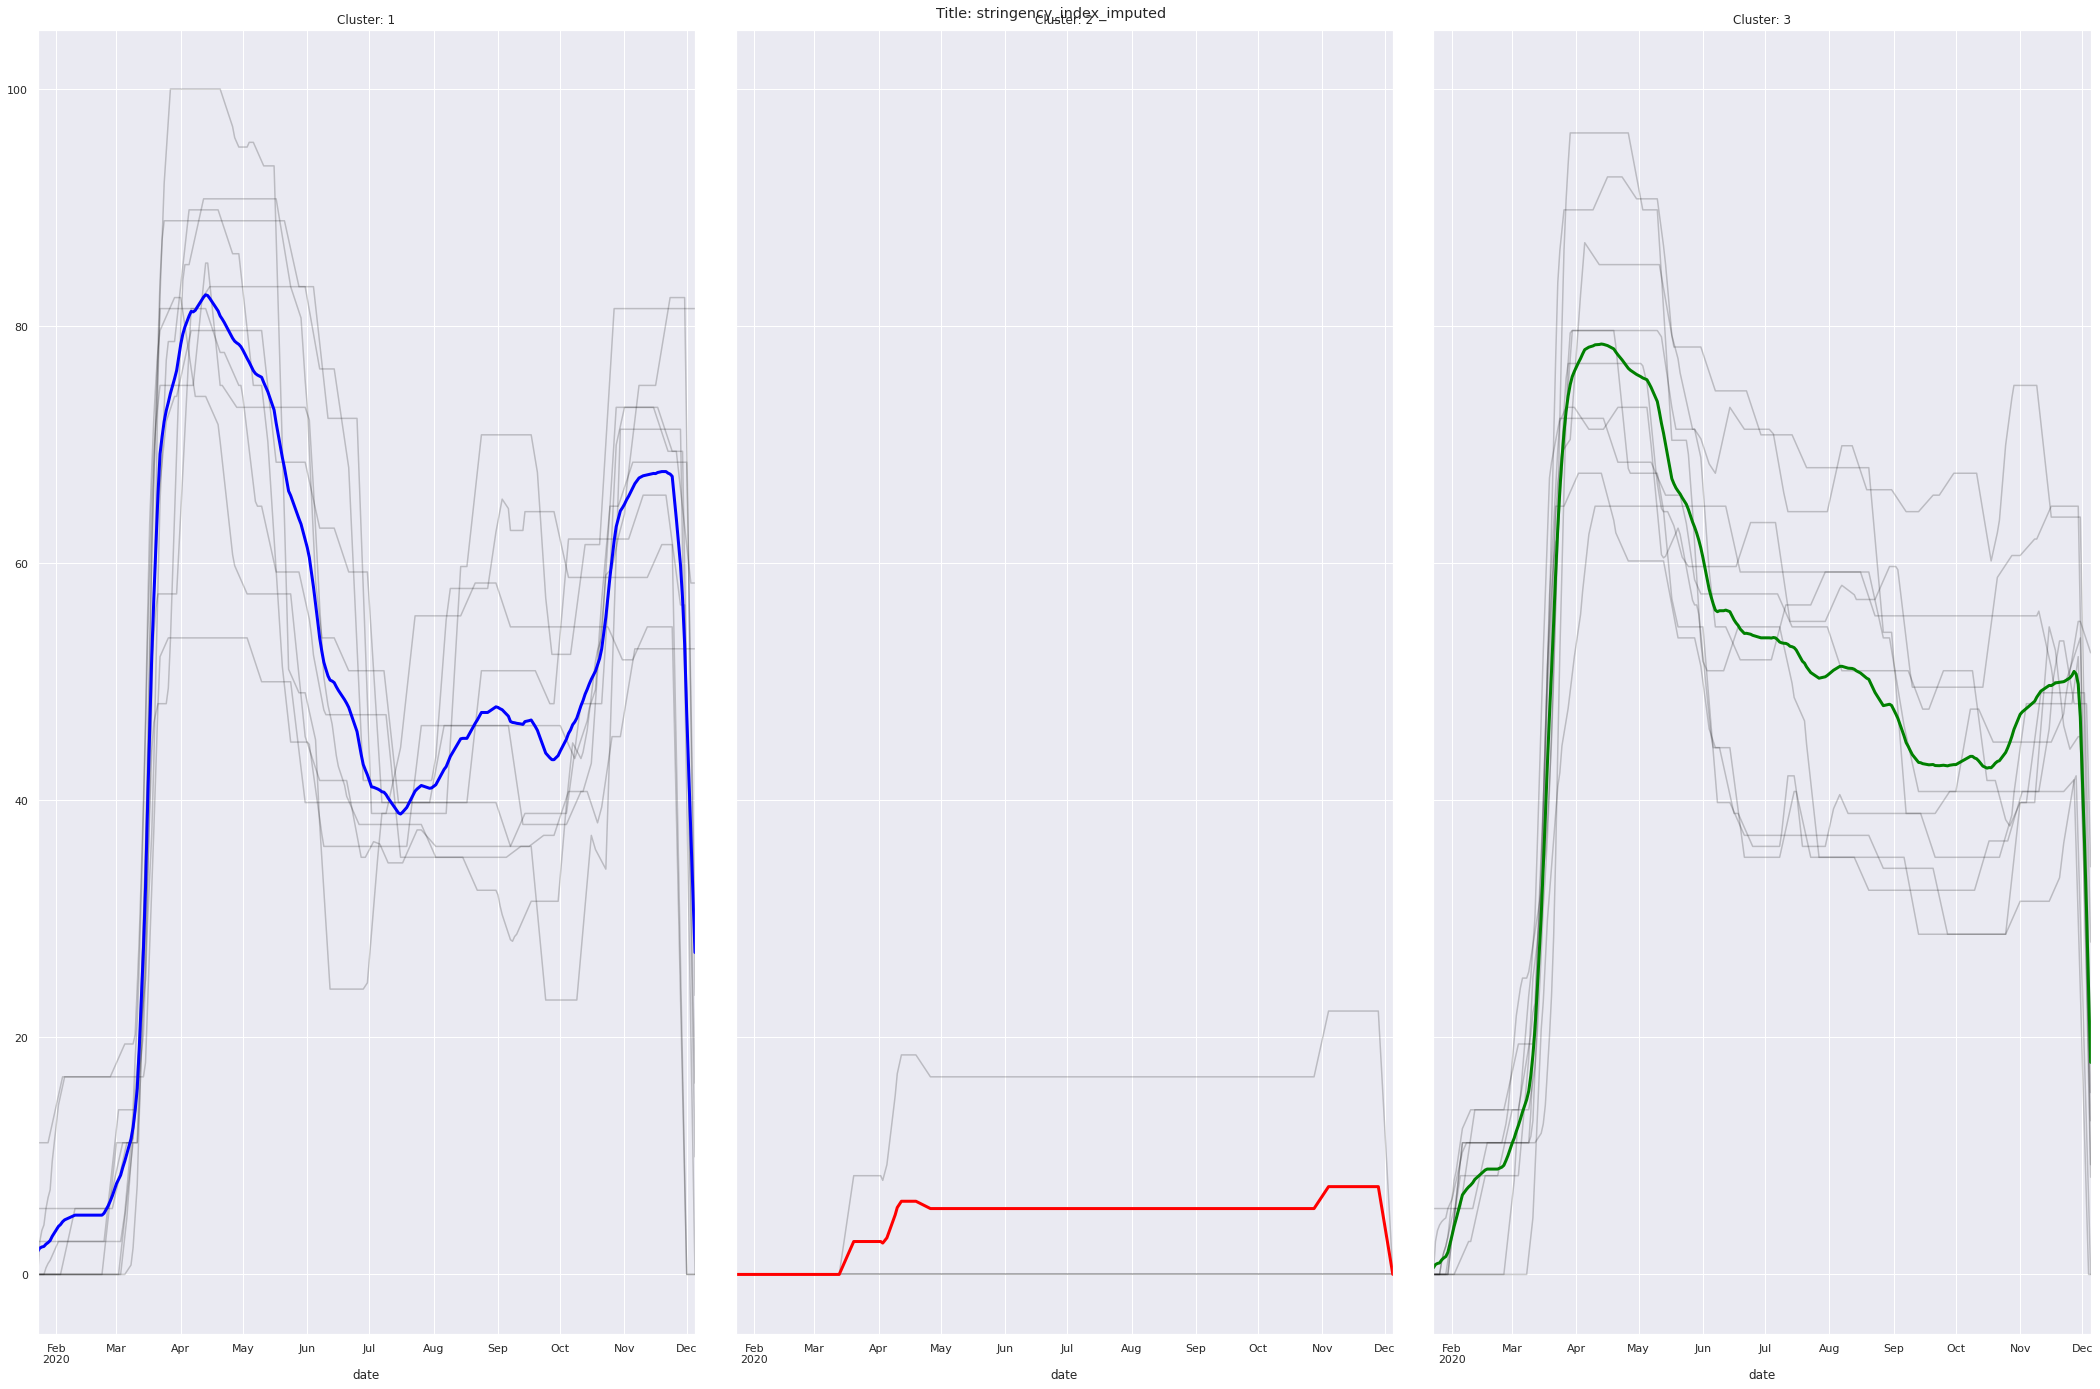

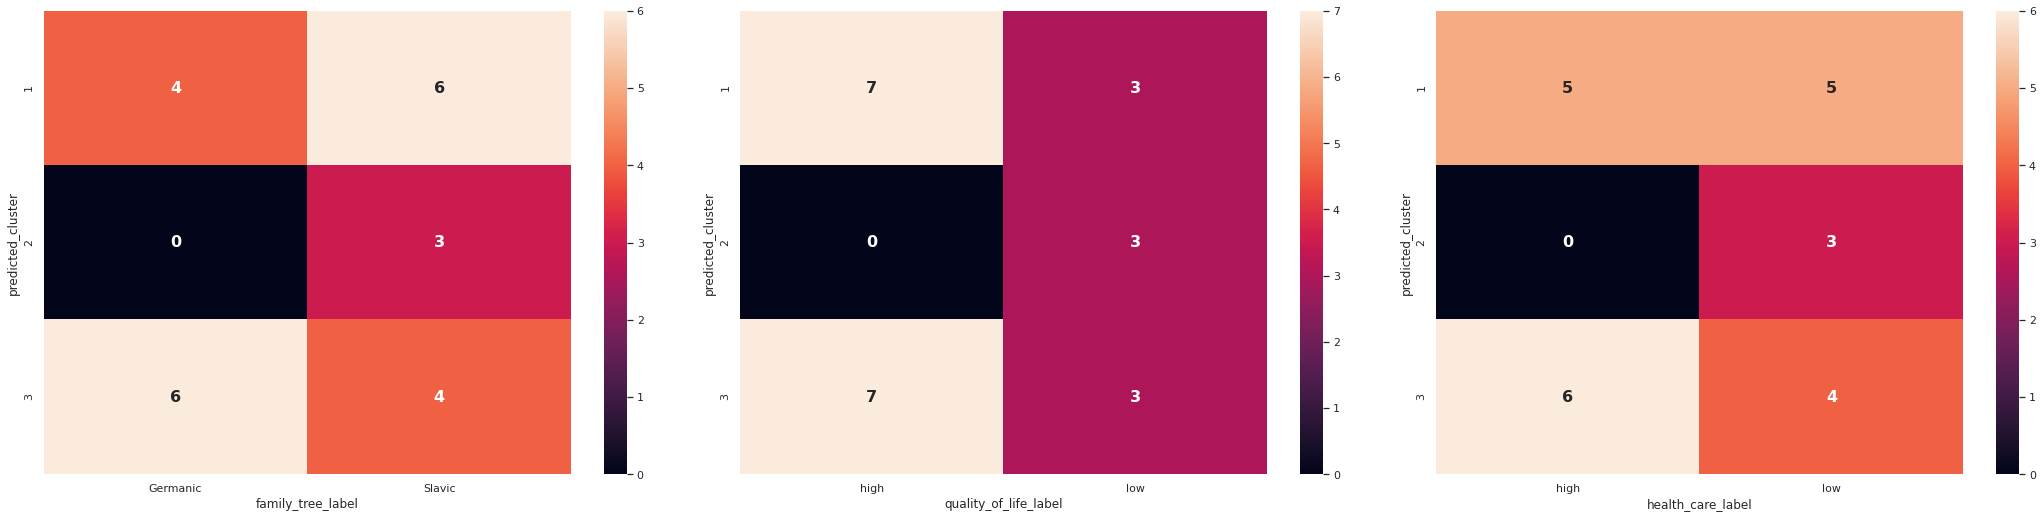

<Figure size 864x864 with 0 Axes>

In [145]:
ts_list = ['new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']

for i in ts_list:
    covid_europe_ts = covid_europe_gs[['location','date','new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']]
    covid_europe_ts['date']= pd.to_datetime(covid_europe_ts['date'])
    covid_europe_ts = covid_europe_ts.pivot(index='location', columns='date', values=i)
    covid_europe_ts = covid_europe_ts.rolling(7, axis=1, min_periods=1).mean().fillna(0)

    model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=1)
    X = to_time_series_dataset(covid_europe_ts.copy())
    labels = model.fit_predict(X)

    clusters = pd.Series(data=labels, index=covid_europe_ts.index)

    colors = ['blue', 'red', 'green']
    names = ['blue cluster', 'red cluster', 'green cluster']

    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(30, 20))
    
    for cluster, ax in zip([0,1,2],[ax1,ax2,ax3]):
        data = covid_europe_ts.loc[clusters[clusters == cluster].index]
        data.T.plot(legend=False, alpha=.2,color='black', ax=ax)
        data.mean(axis=0).plot(linewidth=3., color=colors[cluster], ax=ax)
        ax.set_title("Cluster: " + str(cluster + 1))
    f.suptitle('Title: ' + i)
    plt.tight_layout(pad=3.0)
    # plt.show()

    location_cluster = {'location': covid_europe_ts.index, 'predicted_cluster': 1 + labels}
    location_cluster = pd.DataFrame(location_cluster)
    location_clusters = location_cluster.set_index('location').join(covid_europe_class)
    location_clusters = location_clusters.reset_index()
    
    f, (ax5, ax6, ax7) = plt.subplots(1, 3, figsize=(30,8))
    annot_kws={'fontsize':16, 'weight': 'bold'}
    
    cluster_list = ['family_tree_label', 'quality_of_life_label','health_care_label']
    for i, ax in zip(cluster_list,[ax5,ax6,ax7]):
        ct_cluster = pd.crosstab(index=location_clusters['predicted_cluster'], columns=location_clusters[i])
        sns.heatmap(ct_cluster, annot = True, ax=ax, annot_kws=annot_kws)
    plt.tight_layout(pad=3.0) 
    plt.show()
    plt.subplots_adjust(bottom = 0.2);